# Suncorp Take Home Assignment - Claim Prediction

### Problem Statement
Our claims handlers spend a lot of time going through claim characteristics and inputting cost estimates, which are crucial for managing our reserves but are currently inaccurate and inconsistent, requiring frequent adjustments. Additionally, identifying complex claims and triaging them to the appropriate handlers is challenging, so early detection and proper management of these claims would greatly improve efficiency.

### Objective
1. Develop a model to predict the claim amount for each claim.
2. Develop a method to detect claims that are potentially complex and should be triaged to the appropriate team.

#### Table of Contents
1. Exploratory Data Analysis
2. Data Preprocessing
3. Model Building
4. Summary

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import KBinsDiscretizer

from data_processing import DataProcessing
data_processing = DataProcessing(path='../data/data.csv')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

### Exploratory Data Analysis (EDA)

In [3]:
# Explaination of each column
# ClaimNumber: Unique policy identifier
# DateTimeOfAccident: Date and time of accident
# DateReported: Date that accident was reported
# Age: Age of worker
# Gender: Gender of worker
# MaritalStatus: Martial status of worker. (M)arried, (S)ingle, (U)nknown.
# DependentChildren: The number of dependent children
# DependentsOther: The number of dependants excluding children
# WeeklyWages: Total weekly wage
# PartTimeFullTime: Binary (P) or (F)
# HoursWorkedPerWeek: Total hours worked per week
# DaysWorkedPerWeek: Number of days worked per week
# ClaimDescription: 12 continuous variables pointing out to useful keywords
# InitialIncurredClaimCost: Initial estimate by the insurer of the claim cost
# UltimateIncurredClaimCost: Total claims payments by the insurance company.

In [4]:
claim_df = pd.read_csv('../data/data.csv')

In [5]:
# check null values for all features
claim_df.isnull().sum()

ClaimNumber                    0
DateTimeOfAccident             0
DateReported                   0
Age                            0
Gender                         0
MaritalStatus                 29
DependentChildren              0
DependentsOther                0
WeeklyWages                    0
PartTimeFullTime               0
HoursWorkedPerWeek             0
DaysWorkedPerWeek              0
ClaimDescriptionKeyword_0      0
ClaimDescriptionKeyword_1      0
ClaimDescriptionKeyword_2      0
ClaimDescriptionKeyword_3      0
ClaimDescriptionKeyword_4      0
ClaimDescriptionKeyword_5      0
ClaimDescriptionKeyword_6      0
ClaimDescriptionKeyword_7      0
ClaimDescriptionKeyword_8      0
ClaimDescriptionKeyword_9      0
ClaimDescriptionKeyword_10     0
ClaimDescriptionKeyword_11     0
InitialIncurredClaimsCost      0
UltimateIncurredClaimCost      0
dtype: int64

From the stats we can see MaritalStatus has null value, we will check it later.

In [6]:
# check the data type of each feature
claim_df.dtypes

ClaimNumber                    object
DateTimeOfAccident             object
DateReported                   object
Age                             int64
Gender                         object
MaritalStatus                  object
DependentChildren               int64
DependentsOther                 int64
WeeklyWages                   float64
PartTimeFullTime               object
HoursWorkedPerWeek            float64
DaysWorkedPerWeek               int64
ClaimDescriptionKeyword_0     float64
ClaimDescriptionKeyword_1     float64
ClaimDescriptionKeyword_2     float64
ClaimDescriptionKeyword_3     float64
ClaimDescriptionKeyword_4     float64
ClaimDescriptionKeyword_5     float64
ClaimDescriptionKeyword_6     float64
ClaimDescriptionKeyword_7     float64
ClaimDescriptionKeyword_8     float64
ClaimDescriptionKeyword_9     float64
ClaimDescriptionKeyword_10    float64
ClaimDescriptionKeyword_11    float64
InitialIncurredClaimsCost       int64
UltimateIncurredClaimCost     float64
dtype: objec

#### Explore Time Series Features
DateTimeOfAccident, DateReported

In [7]:
# transfer datetime to datetime type
claim_df['DateTimeOfAccident'] = pd.to_datetime(claim_df['DateTimeOfAccident'])
claim_df['DateReported'] = pd.to_datetime(claim_df['DateReported'])

In [8]:
# check the time range of the DateTimeOfAccident
print('Mim DateTimeOfAccident:', claim_df['DateTimeOfAccident'].min())
print('Max DateTimeOfAccident:', claim_df['DateTimeOfAccident'].max())

# check the time range of the DateTimeOfAccident
print('Mim DateReported:', claim_df['DateReported'].min())
print('Max DateReported:', claim_df['DateReported'].max())

Mim DateTimeOfAccident: 1988-01-01 09:00:00+00:00
Max DateTimeOfAccident: 2005-12-31 10:00:00+00:00
Mim DateReported: 1988-01-08 00:00:00+00:00
Max DateReported: 2006-09-23 00:00:00+00:00


/var/folders/7d/ybg4b9fd0klcqvj67rnbsfk40000gn/T/ipykernel_69245/3486633602.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = claim_df.set_index('DateTimeOfAccident').resample('M').size()


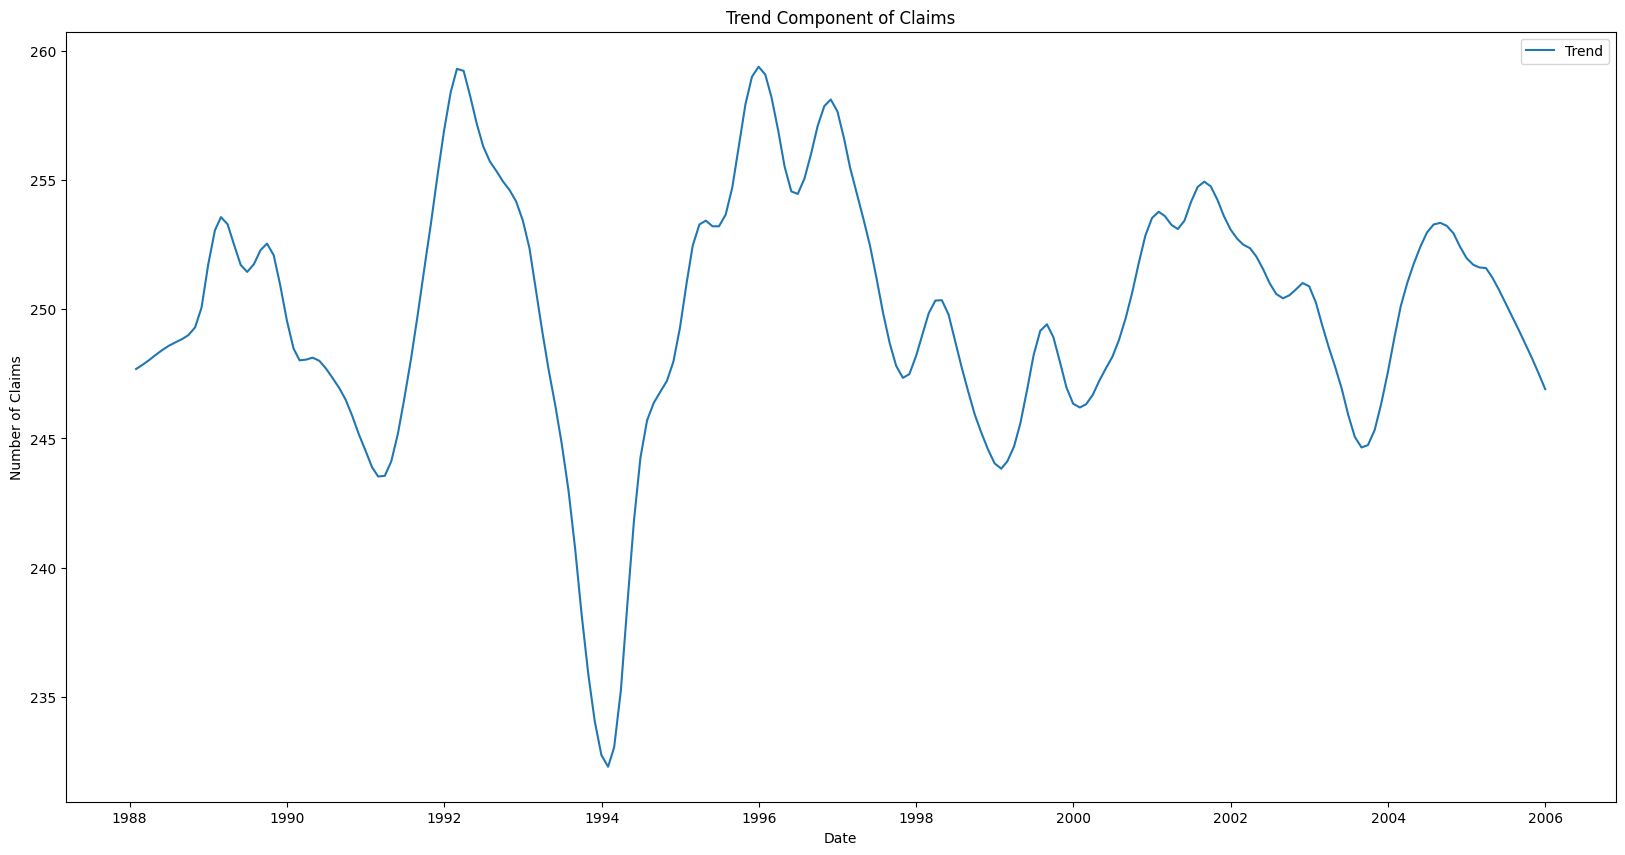

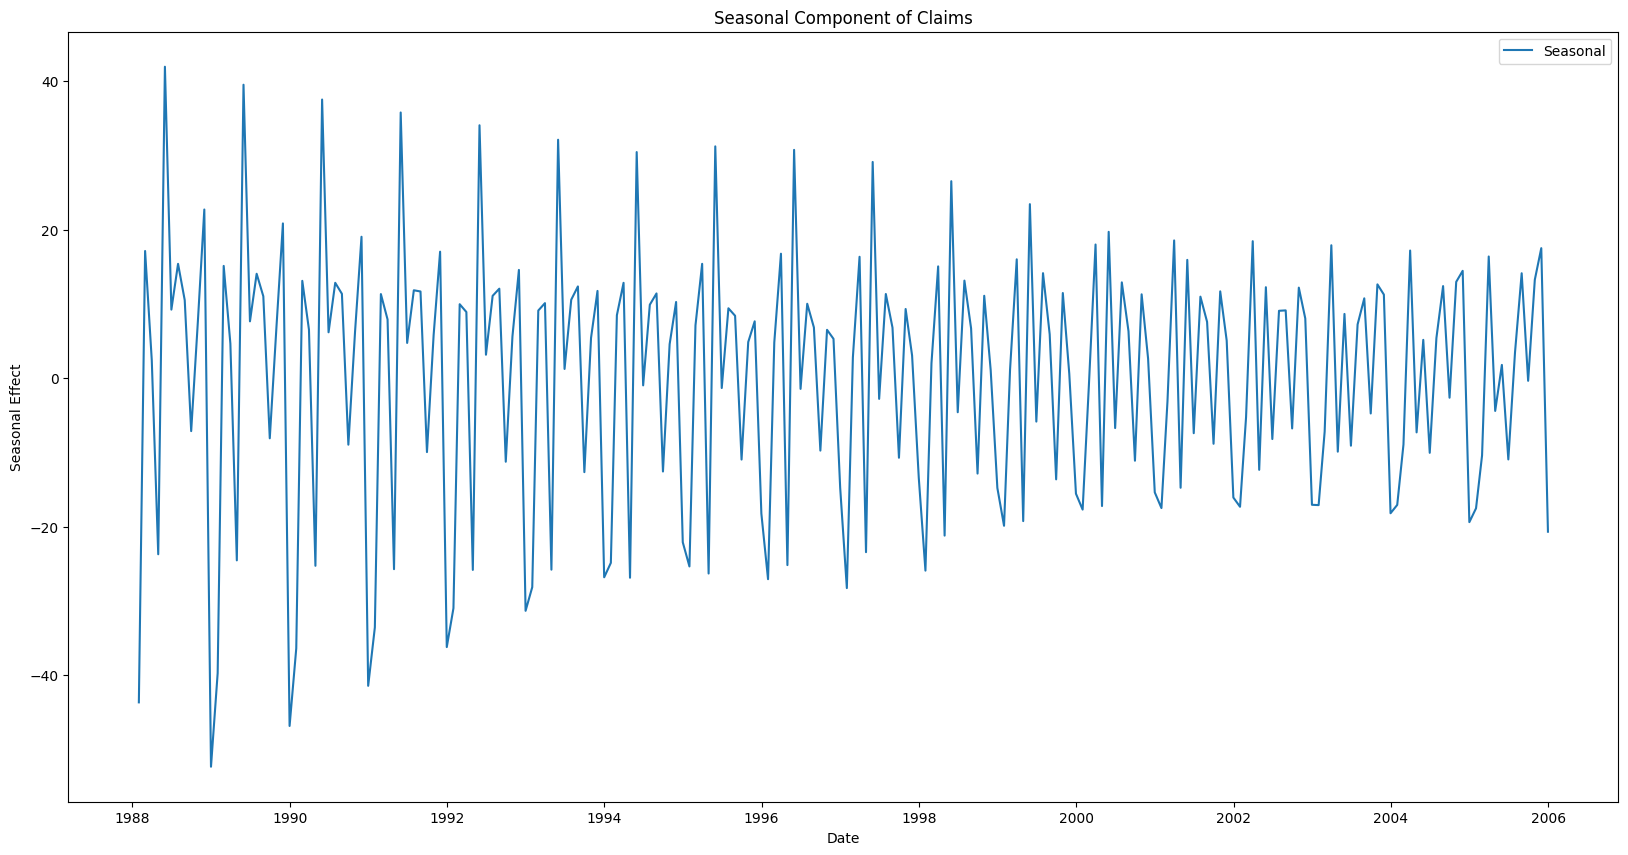

In [9]:
##### Date time Exploration #####
# check the trending and seasonal pattern of the claims
claim_df['DateTimeOfAccident'] = pd.to_datetime(claim_df['DateTimeOfAccident'], errors='coerce')
monthly_data = claim_df.set_index('DateTimeOfAccident').resample('M').size()

stl = STL(monthly_data, seasonal=13)
result = stl.fit()

# Plot the trend component
plt.figure(figsize=(20, 10))
plt.plot(result.trend, label='Trend')
plt.title('Trend Component of Claims')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.show()

# Plot the seasonal component
plt.figure(figsize=(20, 10))
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Component of Claims')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

From the trend and seasonal component, we can see that there is a clear seasonality in the data. 
The number of claims is higher in the middle of the year and lower at the beginning and end of the year.

In [10]:
# add new time related features to the dataset
claim_df = data_processing.transform_datetime_data(claim_df)

INFO:data_processing:Transforming datetime data
INFO:data_processing:Creating accident time related features
INFO:data_processing:Creating report time related features
INFO:data_processing:Creating interval of date between accident and report date time
INFO:data_processing:Create new features: WeekDayOfAccident, MonthOfAccident, YearOfAccident, HourOfAccident, MonthOfReport, YearOfReport, IntervalofDay, IntervalofYear
INFO:data_processing:Drop the original time related features: DateTimeOfAccident, DateReported, IntervalOfTime


In [11]:
# visualize the distribution of the interval time
print('Average interal time:', int(claim_df['IntervalofDay'].mean()))
print('Median interal time:', claim_df['IntervalofDay'].median())
print('Maximum interal time:', claim_df['IntervalofDay'].max())
print('Mim interal time:', claim_df['IntervalofDay'].min())

Average interal time: 38
Median interal time: 21.0
Maximum interal time: 1094
Mim interal time: 0


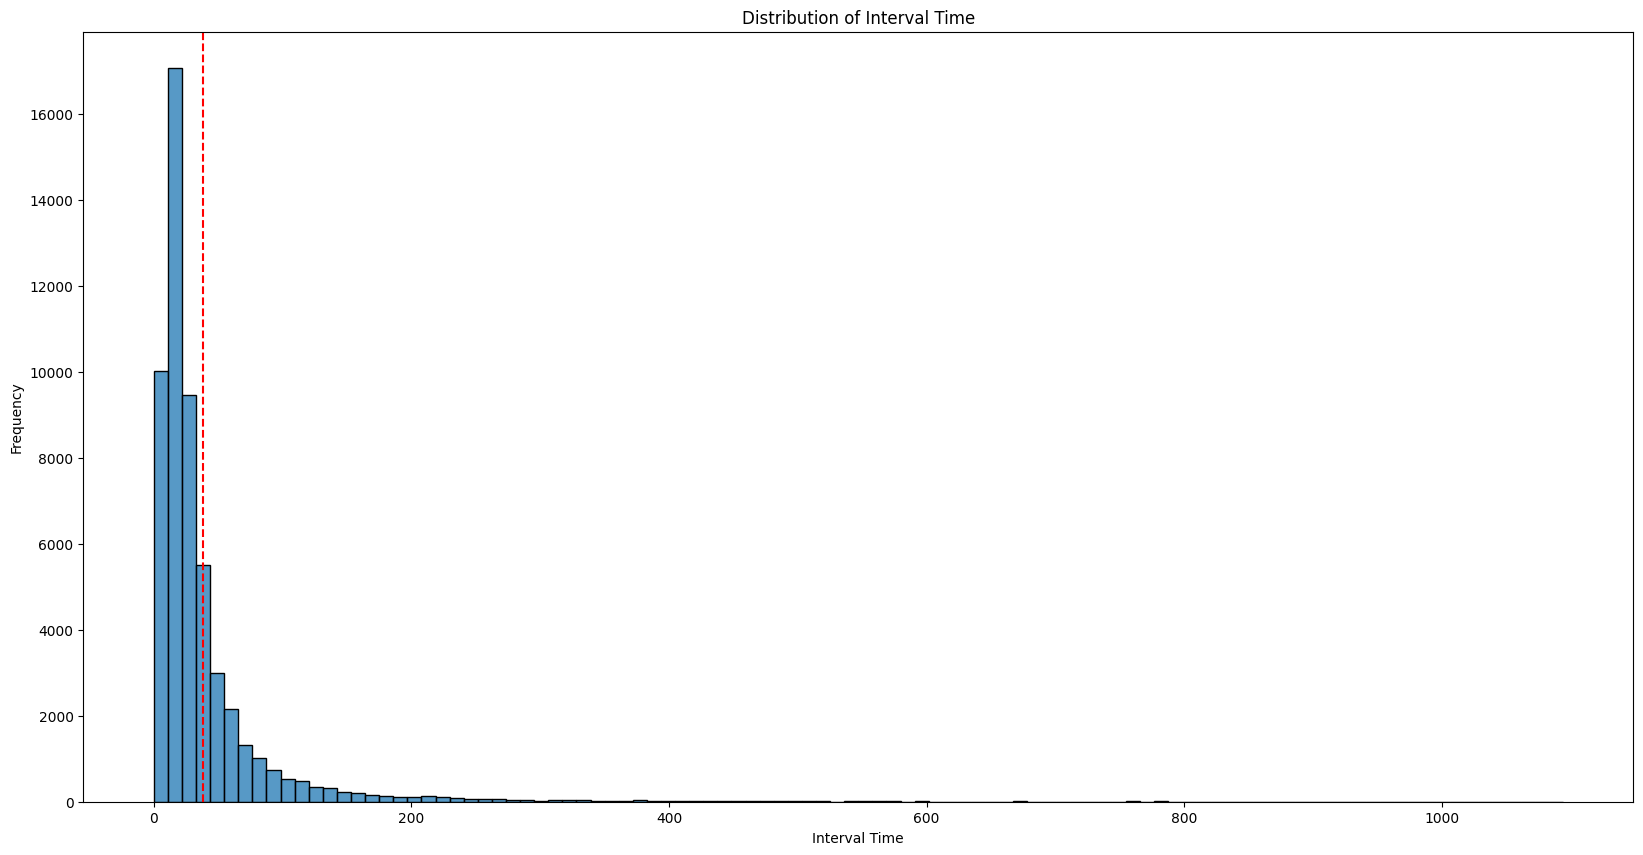

In [12]:
# Distribution of Interval Time
plt.figure(figsize=(20, 10))
sns.histplot(claim_df['IntervalofDay'], bins=100)
plt.axvline(x=38, color='r', linestyle='--')
plt.title('Distribution of Interval Time')
plt.xlabel('Interval Time')
plt.ylabel('Frequency')
plt.show()

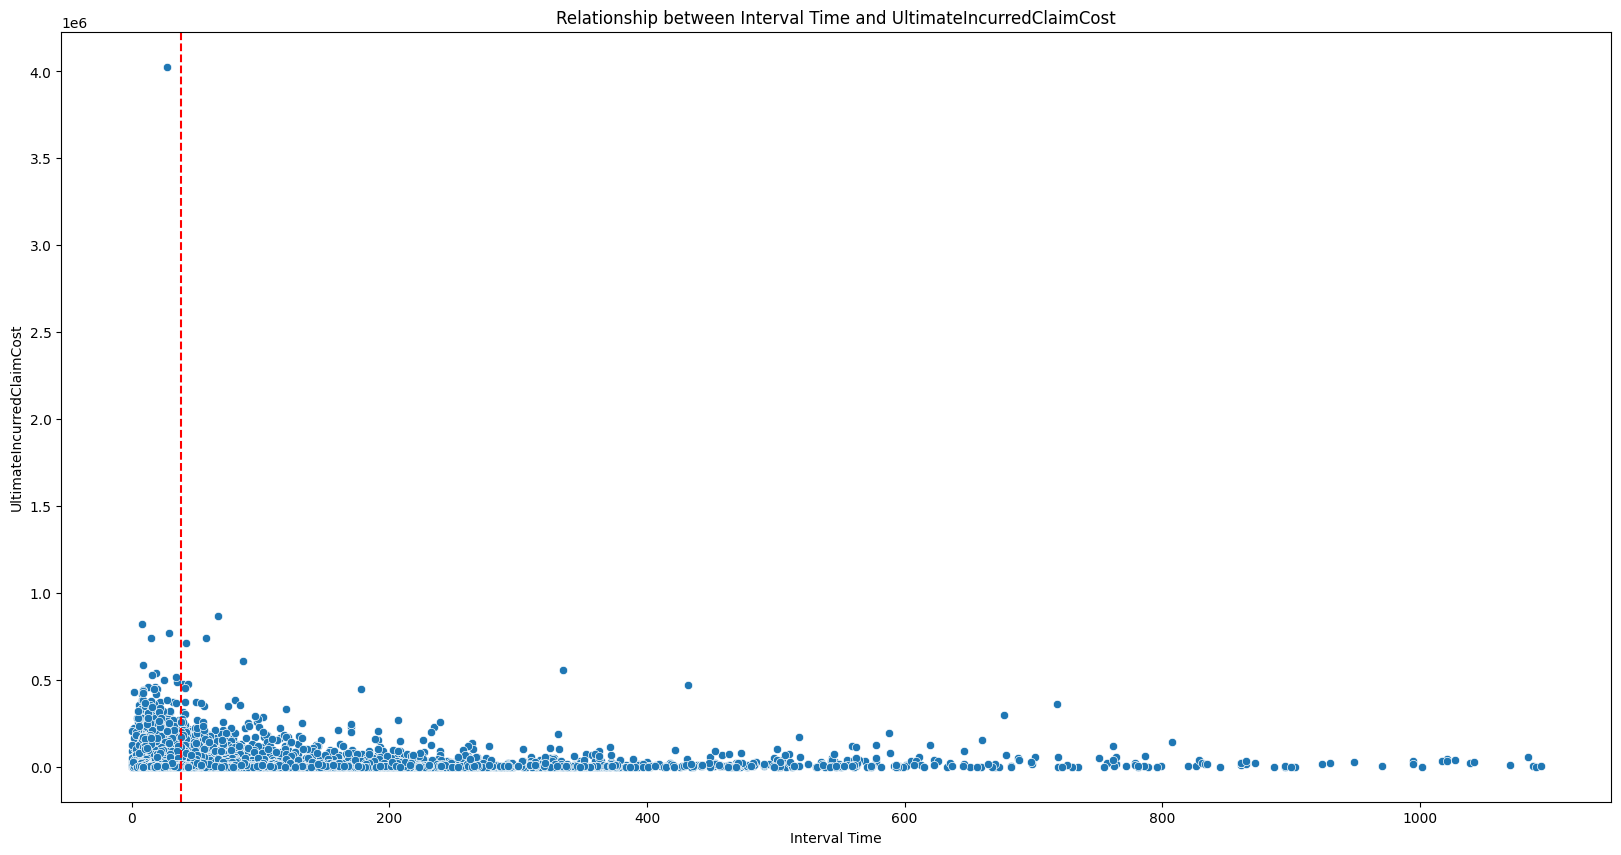

In [13]:
# relationship between Interval Time and UltimateIncurredClaimCost
plt.figure(figsize=(20, 10))
sns.scatterplot(x='IntervalofDay', y='UltimateIncurredClaimCost', data=claim_df)
plt.axvline(x=38, color='r', linestyle='--')
plt.title('Relationship between Interval Time and UltimateIncurredClaimCost')
plt.xlabel('Interval Time')
plt.ylabel('UltimateIncurredClaimCost')
plt.show()



The graph shows that most claims tend to have lower costs, especially as the interval time increases. This might suggest that claims not reported quickly tend to be less severe or that early intervention helps manage costs better.

#### Explore Personal Related Features
Gender, MaritalStatus, Age, DependentChildren, DependentsOther

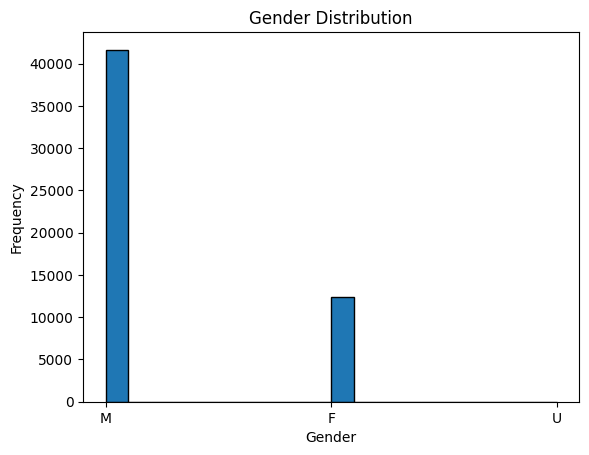

In [14]:
##### Gender Feature #####
# check gender distribution
claim_df['Gender'].value_counts()

# check the distribution of the gender
plt.hist(claim_df['Gender'], bins=20, edgecolor='k')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution')
plt.show()

No action required for Gender data for now.

Percentage of Married: 0.416962962962963
Percentage of Single: 0.484462962962963
Percentage of Unknown: 0.09803703703703703
Percentage of Missing Value: 0.000537037037037037


/var/folders/7d/ybg4b9fd0klcqvj67rnbsfk40000gn/T/ipykernel_69245/4219315571.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  claim_df['MaritalStatus'].fillna('U', inplace=True)


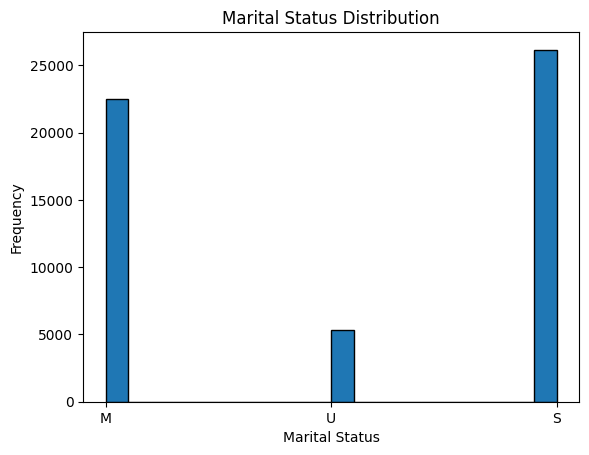

In [15]:
##### MaritalStatus Feature #####
# check marital status distribution
claim_df['MaritalStatus'].value_counts()
print('Percentage of Married:', claim_df['MaritalStatus'].value_counts()['M'] / len(claim_df))
print('Percentage of Single:', claim_df['MaritalStatus'].value_counts()['S'] / len(claim_df))
print('Percentage of Unknown:', claim_df['MaritalStatus'].value_counts()['U'] / len(claim_df))

# check null value in MaritalStatus
claim_df['MaritalStatus'].isnull().sum()
print('Percentage of Missing Value:', claim_df['MaritalStatus'].isnull().sum() / len(claim_df))

# fill the missing value with U
claim_df['MaritalStatus'].fillna('U', inplace=True)
claim_df = data_processing.clean_missing_data(claim_df)

# check the distribution of the marital status
plt.hist(claim_df['MaritalStatus'], bins=20, edgecolor='k')
plt.xlabel('Marital Status')
plt.ylabel('Frequency')
plt.title('Marital Status Distribution')
plt.show()

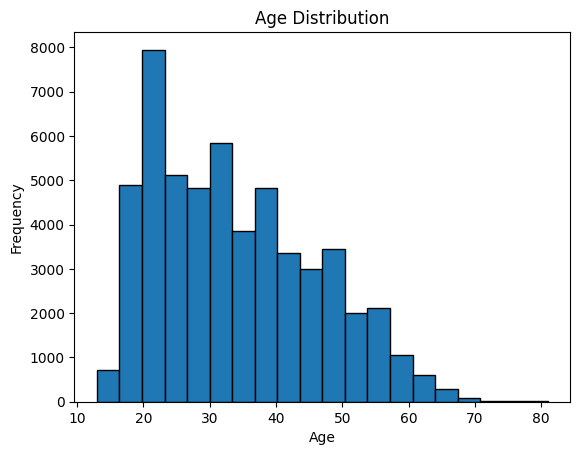

In [16]:
##### Age #####
# Histogram to visualize the distribution
plt.hist(claim_df['Age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [17]:
# apply binning to the age feature
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
claim_df['AgeCategory'] = bins.fit_transform(claim_df[['Age']])

# check the distribution of the age category
claim_df['AgeCategory'].value_counts()

AgeCategory
1.0    19347
0.0    18687
2.0    11800
3.0     4052
4.0      114
Name: count, dtype: int64

In [18]:
##### Dependent #####
# Sum up the number of dependents
claim_df['TotalDependents'] = claim_df['DependentChildren'] + claim_df['DependentsOther']

print('Percentage of Records with Dependents:', claim_df[claim_df['TotalDependents'] > 0].shape[0] / len(claim_df))

Percentage of Records with Dependents: 0.06546296296296296


#### Employment Features
PartTimeFullTime, WeeklyWages, HoursWorkedPerWeek, DaysWorkedPerWeek

In [19]:
##### PartTimeFullTime #####
# check part time full time distribution
claim_df['PartTimeFullTime'].value_counts()

print('Percentage of Part Time:', claim_df['PartTimeFullTime'].value_counts()['P'] / len(claim_df))
print('Percentage of Full Time:', claim_df['PartTimeFullTime'].value_counts()['F'] / len(claim_df))

Percentage of Part Time: 0.09051851851851851
Percentage of Full Time: 0.9094814814814814


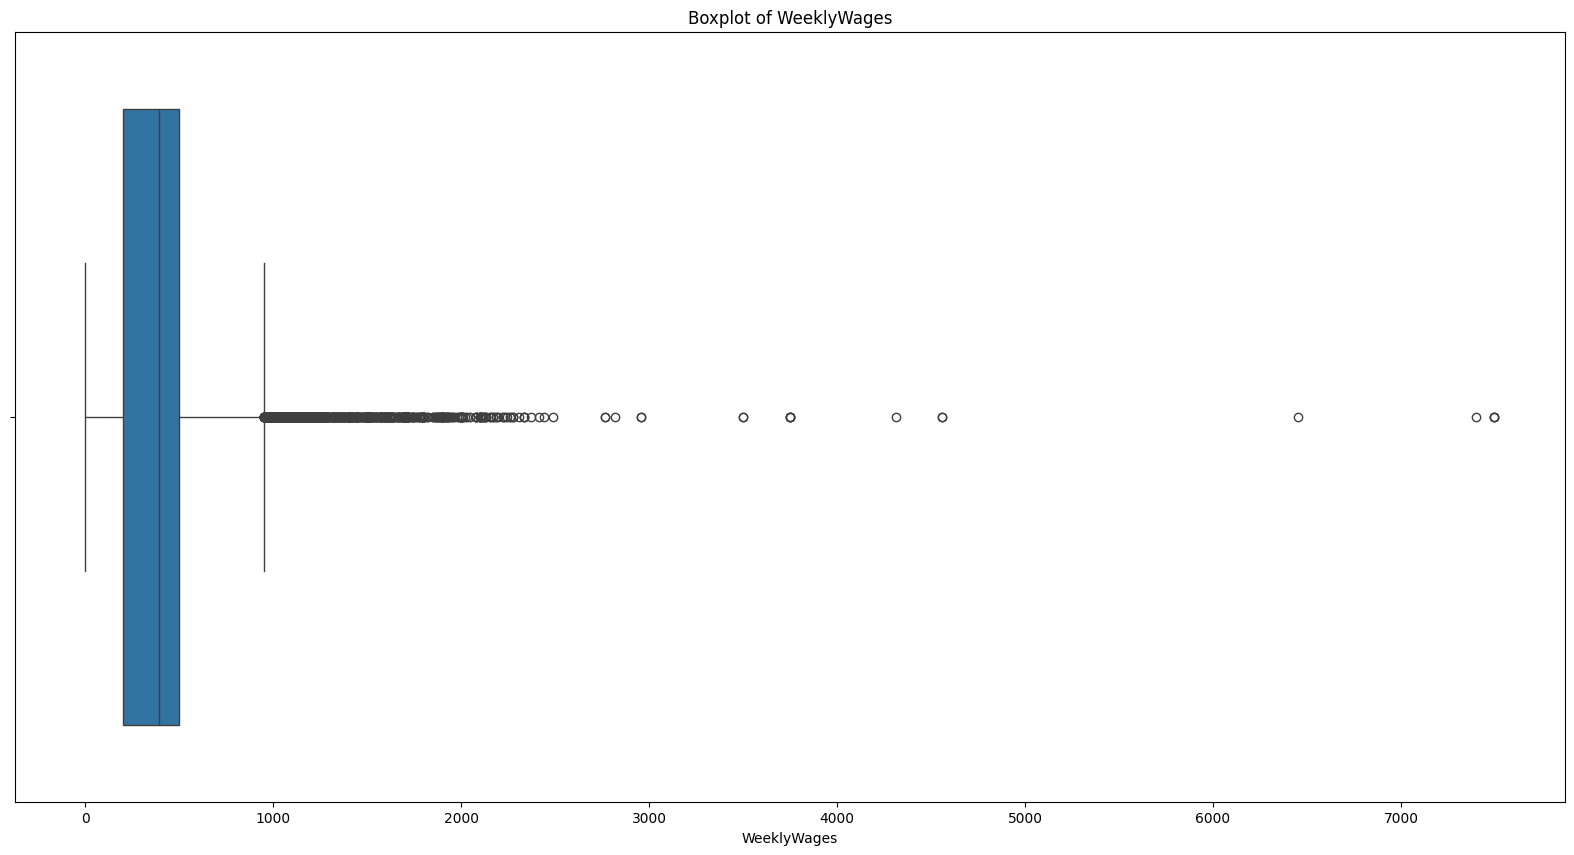

In [20]:
##### WeeklyWages #####
plt.figure(figsize=(20, 10))
sns.boxplot(x='WeeklyWages', data=claim_df)
plt.title('Boxplot of WeeklyWages')
plt.show()

It's possible the weekly wages is more than 1000 dollars, so we will keep it for now

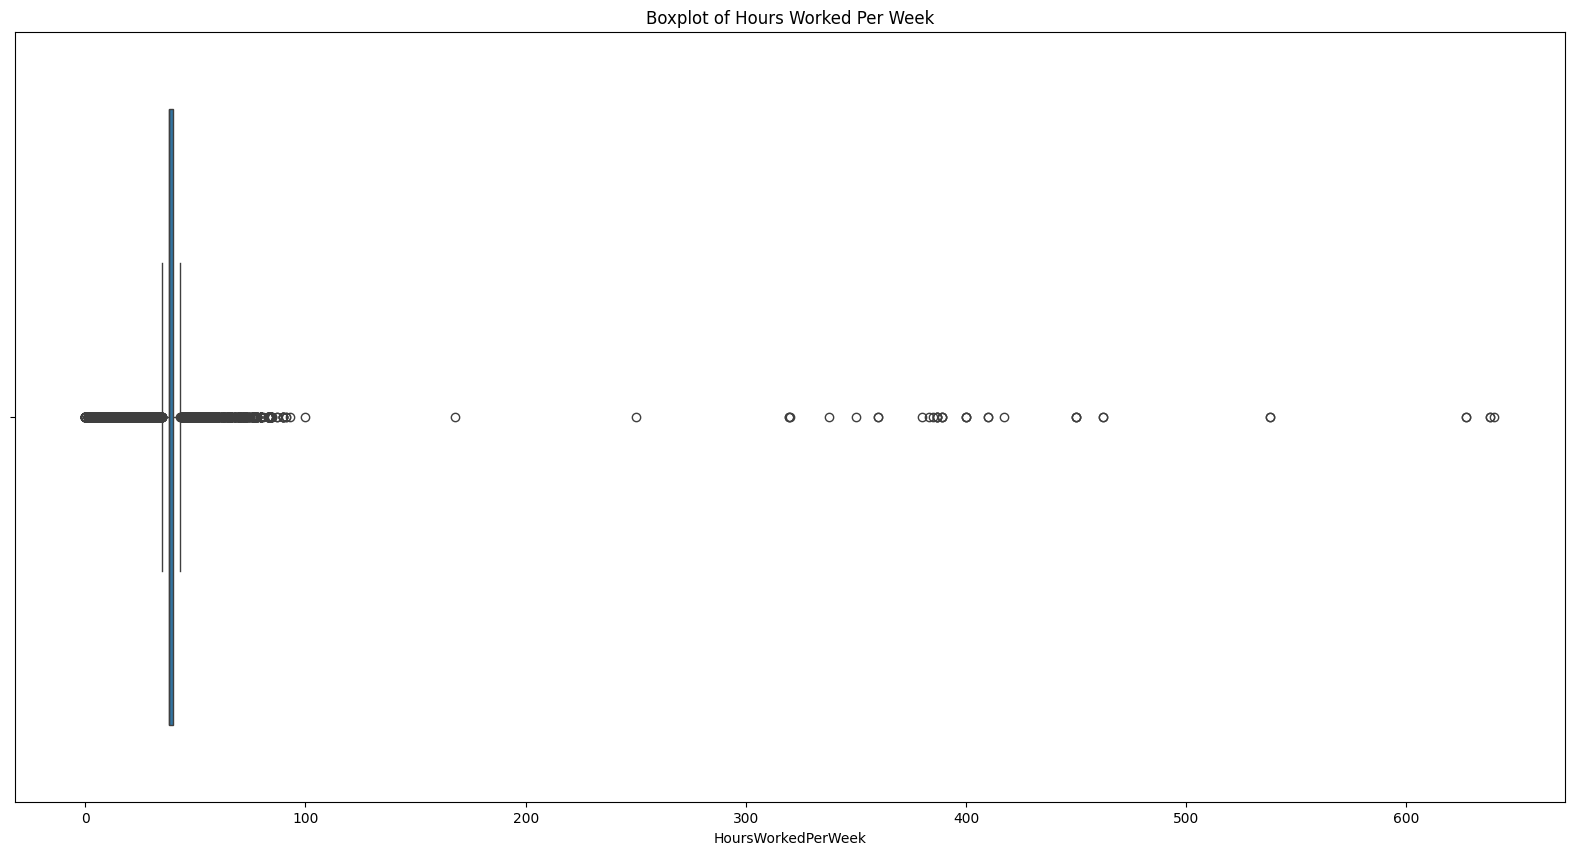

In [21]:
##### HoursWorkedPerWeek #####
# check the outlier of the hours worked per week
plt.figure(figsize=(20, 10))
sns.boxplot(x='HoursWorkedPerWeek', data=claim_df)
plt.title('Boxplot of Hours Worked Per Week')
plt.show()

In [22]:
# ideal hours worked per week should be between 0 and 100, so we will remove the outliers
claim_df = claim_df[(claim_df['HoursWorkedPerWeek'] >= 0) & (claim_df['HoursWorkedPerWeek'] <= 100)]

According to the plots we can see there are some outliers in the HoursWorkedPerWeek and DailyWages columns.
so we made two assumptions:
1. The number of hours worked per week is between 0 and 100.
2. The number of days worked per week is not 0.

In [23]:
# calculate the hourly wages and daily wages
claim_df['HourlyWages'] = claim_df.apply(lambda x: x['WeeklyWages'] / x['HoursWorkedPerWeek'] if 0 < x['HoursWorkedPerWeek'] < 100 else 0, axis=1)
claim_df['DailyWages'] = claim_df.apply(lambda x: x['WeeklyWages'] / x['DaysWorkedPerWeek'] if x['DaysWorkedPerWeek'] != 0 else 0, axis=1)


In [24]:
# standardize 'WeeklyWages', 'HoursWorkedPerWeek', 'HourlyWages', 'DailyWages'
claim_df['WeeklyWages'] = (claim_df['WeeklyWages'] - claim_df['WeeklyWages'].mean()) / claim_df['WeeklyWages'].std()
claim_df['HoursWorkedPerWeek'] = (claim_df['HoursWorkedPerWeek'] - claim_df['HoursWorkedPerWeek'].mean()) / claim_df['HoursWorkedPerWeek'].std()
claim_df['HourlyWages'] = (claim_df['HourlyWages'] - claim_df['HourlyWages'].mean()) / claim_df['HourlyWages'].std()
claim_df['DailyWages'] = (claim_df['DailyWages'] - claim_df['DailyWages'].mean()) / claim_df['DailyWages'].std()

In [25]:
# Create Binned Features for WeeklyWages. As we already made assumptions to generate HourlyWages and DailyWages, so we only create binned features for WeeklyWages.
bins = [0, 500, 1000, float('inf')]
labels = ['Low', 'Medium', 'High']
claim_df['WageCatgory'] = pd.cut(claim_df['WeeklyWages'], bins=bins, labels=labels)

In [26]:
# There is another feature we can consider is overtime.
# For the sake of simplicity, we will assume that the standard working hours is 40 hours per week. 
# For the part-time workers, there is no specific definition of the standard working hours.

# label overtime if overtime hours is greater than 0
claim_df['Overtime'] = claim_df['HoursWorkedPerWeek'].apply(lambda x: 1 if x - 40 > 0 else 0)

#### Explore Description Keywords Features
ClaimDescriptionKeyword_*
The ClaimDescriptionKeyword_* features are already embedded, so we will not do further data preprocessing or feature engineering on them for now

In [27]:
claim_description_keywords_columns= ['ClaimDescriptionKeyword_0', 'ClaimDescriptionKeyword_1',
       'ClaimDescriptionKeyword_2', 'ClaimDescriptionKeyword_3',
       'ClaimDescriptionKeyword_4', 'ClaimDescriptionKeyword_5',
       'ClaimDescriptionKeyword_6', 'ClaimDescriptionKeyword_7',
       'ClaimDescriptionKeyword_8', 'ClaimDescriptionKeyword_9',
       'ClaimDescriptionKeyword_10', 'ClaimDescriptionKeyword_11']

In [28]:
# get duplicated rows
duplicated_rows = claim_df[claim_df.duplicated(claim_description_keywords_columns)]

print('Number of Duplicated Rows:', duplicated_rows.shape[0])

Number of Duplicated Rows: 25945


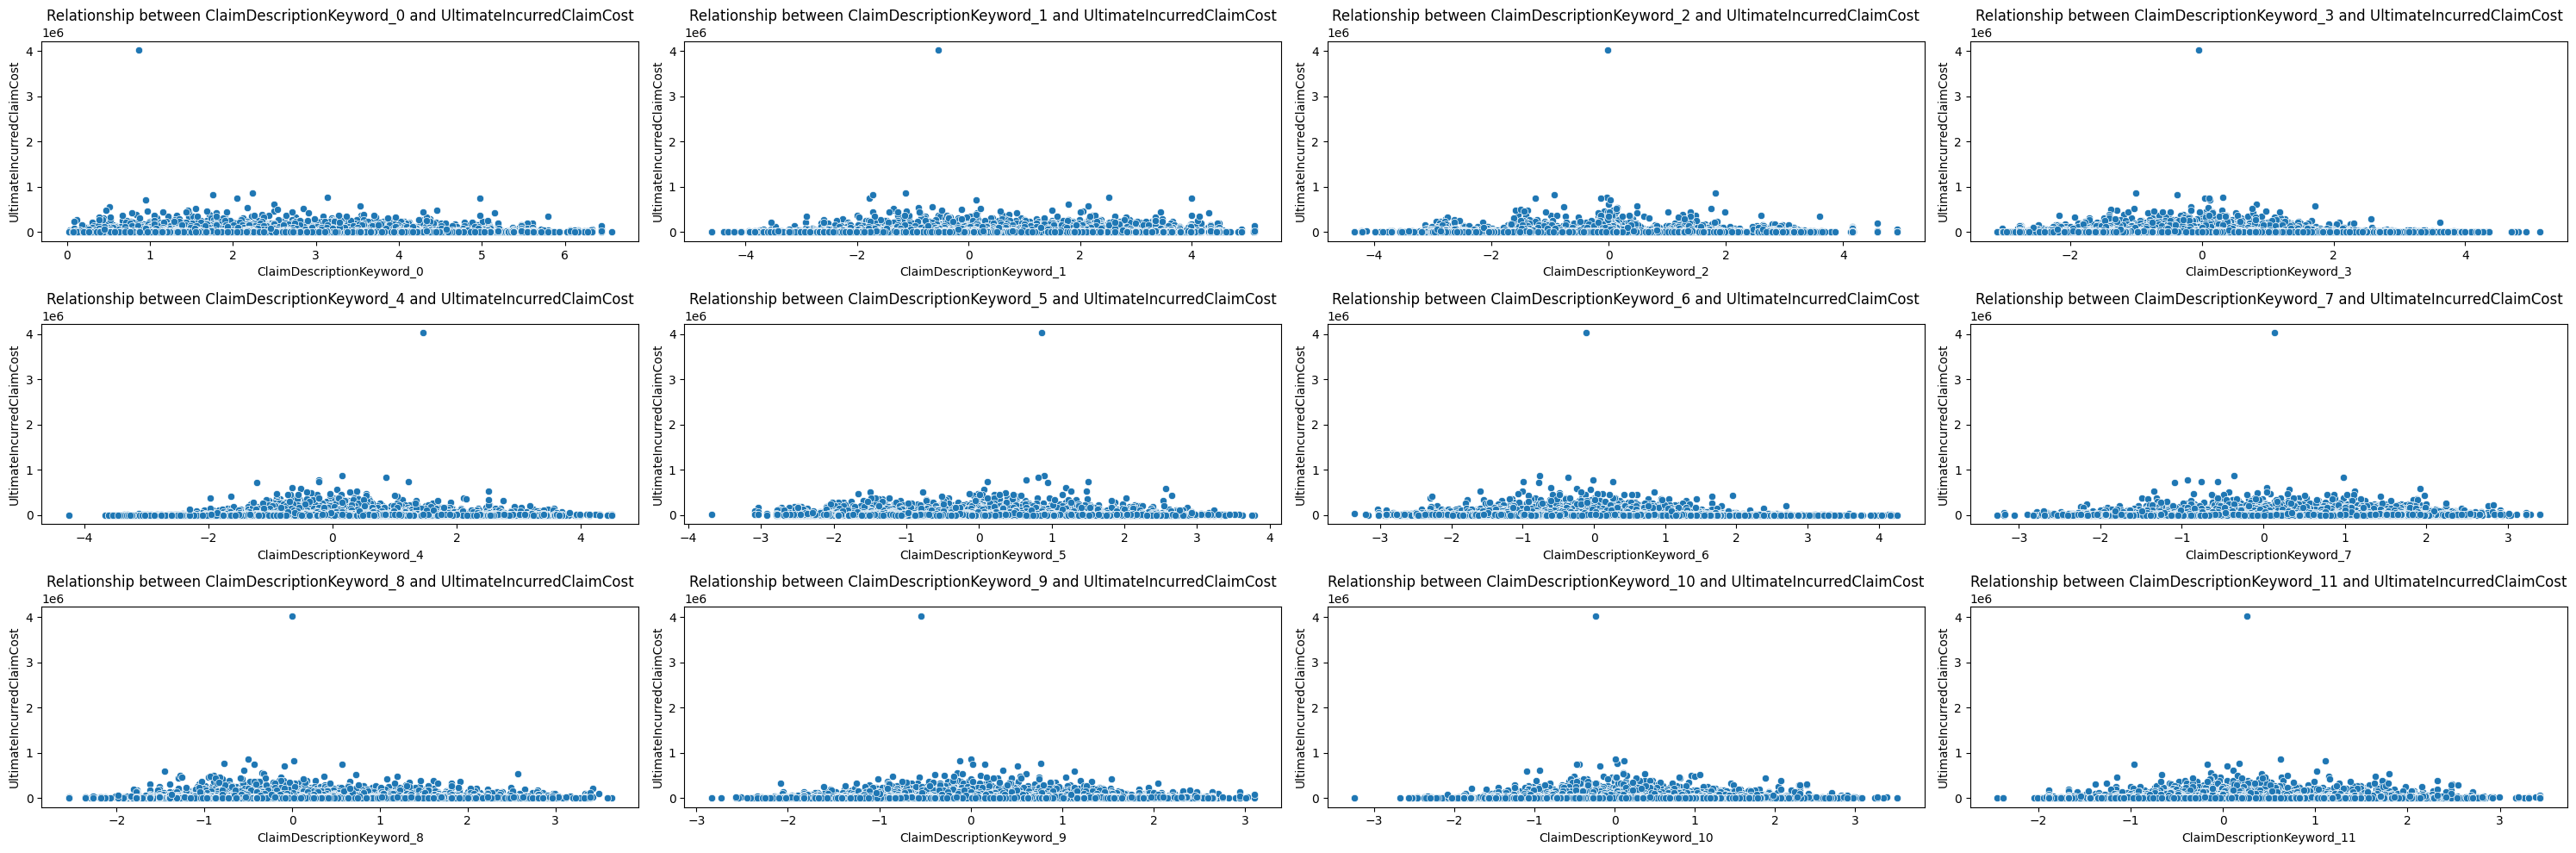

In [29]:
# relationship between UltimateIncurredClaimCost and each claim description keyword
plt.figure(figsize=(30, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    sns.scatterplot(x=claim_description_keywords_columns[i], y='UltimateIncurredClaimCost', data=claim_df)
    plt.title('Relationship between ' + claim_description_keywords_columns[i] + ' and UltimateIncurredClaimCost')
    plt.xlabel(claim_description_keywords_columns[i])
    plt.ylabel('UltimateIncurredClaimCost')
plt.tight_layout()
plt.show()


#### Claim Cost Features
UltimateIncurredClaimCost, InitialIncurredClaimsCost

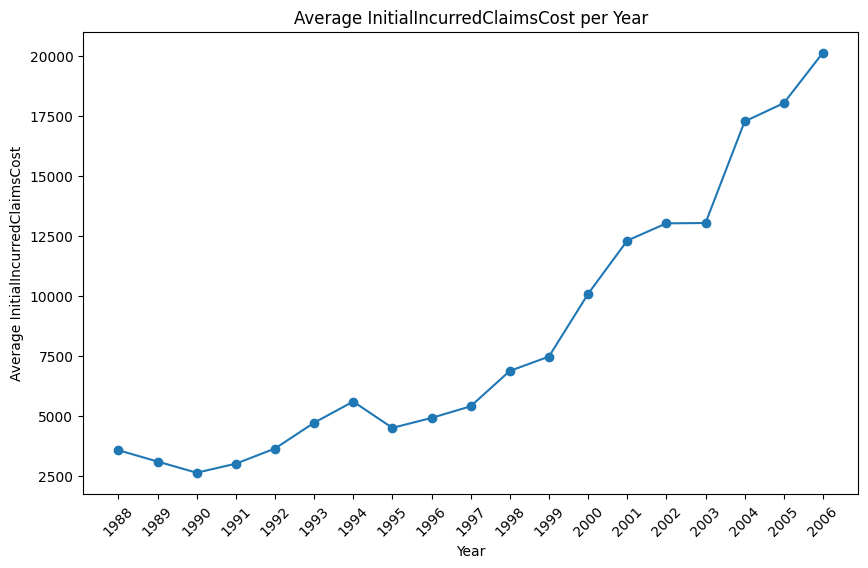

In [30]:
# Calculate the average initial incurred claim cost per year
average_claim_cost_per_year = claim_df.groupby('YearOfReport')['InitialIncurredClaimsCost'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_claim_cost_per_year, marker='o')
plt.title('Average InitialIncurredClaimsCost per Year')
plt.xlabel('Year')
plt.ylabel('Average InitialIncurredClaimsCost')

# Set x-axis labels to actual year values
plt.xticks(ticks=average_claim_cost_per_year.index, labels=average_claim_cost_per_year.index, rotation=45)

plt.show()



In [31]:
# By checking InitialIncurredClaimsCost and UltimateIncurredClaimCost_log, we can find they are right-skewed.
# We can apply log transformation to make them more normally distributed.

# Log transformation
claim_df['InitialIncurredClaimsCost_log'] = np.log1p(claim_df['InitialIncurredClaimsCost'])
claim_df['UltimateIncurredClaimCost_log'] = np.log1p(claim_df['UltimateIncurredClaimCost'])


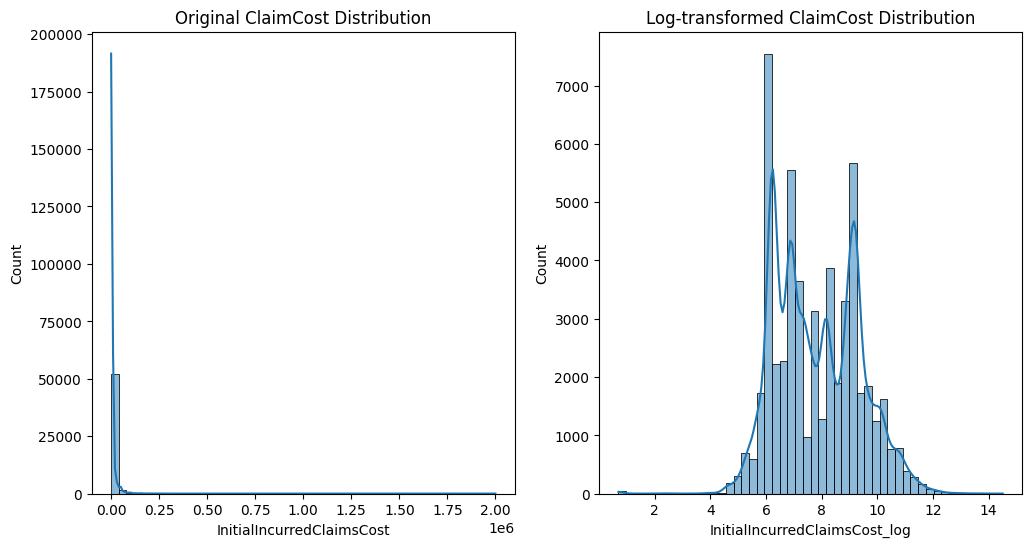

In [32]:
# Visualize the distribution before and after log transformation
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(claim_df['InitialIncurredClaimsCost'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Original ClaimCost Distribution')

sns.histplot(claim_df['InitialIncurredClaimsCost_log'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Log-transformed ClaimCost Distribution')

plt.show()

### Data Preprocessing


In [33]:
# transfer categorical features to dummies
clean_df = data_processing.transfoer_categorical_data(claim_df)
clean_df = clean_df.reset_index(drop=True)

INFO:data_processing:Transforming categorical data for: Gender, MaritalStatus, PartTimeFullTime, WageCatgory
INFO:data_processing:Drop columns: Gender, MaritalStatus, PartTimeFullTime, WageCatgory


In [34]:
clean_df.columns

Index(['ClaimNumber', 'Age', 'DependentChildren', 'DependentsOther',
       'WeeklyWages', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescriptionKeyword_0', 'ClaimDescriptionKeyword_1',
       'ClaimDescriptionKeyword_2', 'ClaimDescriptionKeyword_3',
       'ClaimDescriptionKeyword_4', 'ClaimDescriptionKeyword_5',
       'ClaimDescriptionKeyword_6', 'ClaimDescriptionKeyword_7',
       'ClaimDescriptionKeyword_8', 'ClaimDescriptionKeyword_9',
       'ClaimDescriptionKeyword_10', 'ClaimDescriptionKeyword_11',
       'InitialIncurredClaimsCost', 'UltimateIncurredClaimCost',
       'WeekDayOfAccident', 'MonthOfAccident', 'YearOfAccident',
       'HourOfAccident', 'MonthOfReport', 'YearOfReport', 'IntervalofDay',
       'IntervalofYear', 'AgeCategory', 'TotalDependents', 'HourlyWages',
       'DailyWages', 'Overtime', 'InitialIncurredClaimsCost_log',
       'UltimateIncurredClaimCost_log', 'Gender_F', 'Gender_M', 'Gender_U',
       'MaritalStatus_M', 'MaritalStatus_S', 'Marital

In [35]:
# drop the claim number
corr_df = clean_df.drop(columns=['ClaimNumber'])

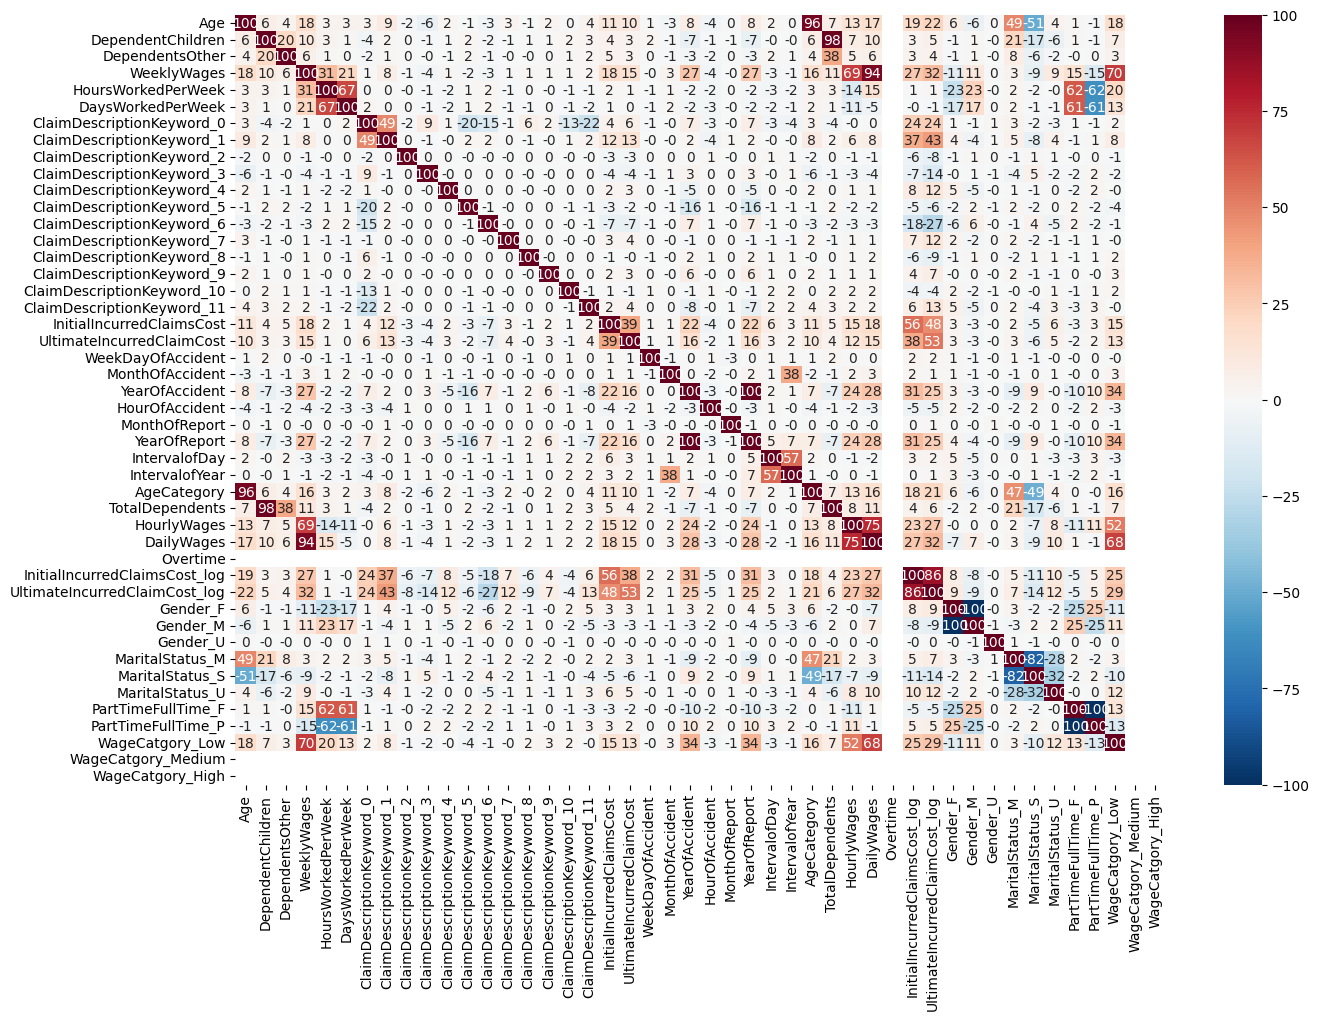

In [36]:
# using the correlation graph to check the correlation between the features
correlations = corr_df.corr()

# Increase the figsize to 7 x 6
plt.figure(figsize=(15,10))

# Plot heatmap of correlations
sns.heatmap(correlations*100, cmap='RdBu_r', annot=True, fmt='0.0f')

plt.show()

In [37]:
# Threshold for selecting significant correlations with the target variable
threshold_target = 0.05
target_variable = 'UltimateIncurredClaimCost_log'

# Identify features with high correlation with the target variable
high_corr_features = correlations[target_variable][abs(correlations[target_variable]) > threshold_target].index.tolist()

# Remove highly correlated features with each other
threshold_features = 0.8
to_remove = set()
for i in range(len(high_corr_features)):
    for j in range(i + 1, len(high_corr_features)):
        if abs(correlations[high_corr_features[i]][high_corr_features[j]]) > threshold_features:
            to_remove.add(high_corr_features[j])

# Final selected features
final_features = [feature for feature in high_corr_features if feature not in to_remove]

# Display the selected features
final_features


['Age',
 'DependentChildren',
 'WeeklyWages',
 'ClaimDescriptionKeyword_0',
 'ClaimDescriptionKeyword_1',
 'ClaimDescriptionKeyword_2',
 'ClaimDescriptionKeyword_3',
 'ClaimDescriptionKeyword_4',
 'ClaimDescriptionKeyword_5',
 'ClaimDescriptionKeyword_6',
 'ClaimDescriptionKeyword_7',
 'ClaimDescriptionKeyword_8',
 'ClaimDescriptionKeyword_9',
 'ClaimDescriptionKeyword_11',
 'InitialIncurredClaimsCost',
 'UltimateIncurredClaimCost',
 'YearOfAccident',
 'HourOfAccident',
 'HourlyWages',
 'InitialIncurredClaimsCost_log',
 'Gender_F',
 'MaritalStatus_M',
 'MaritalStatus_U',
 'PartTimeFullTime_F',
 'WageCatgory_Low']

### Model Building

#### Predict Claim Cost

**Model Selection**

To predict the claim cost, we consider using Decision Tree Regressor model as the base model, and implement the XGBRegressor model to improve the prediction accuracy.

The reason to use decision tree model is that it is easy to interpret and visualize, and it can handle both numerical and categorical data. For the XGBRegressor model, it is an ensemble model that can improve the prediction accuracy by combining multiple decision trees.

**Objective Function**

The objective function of the XGBRegressor model is to minimize the mean squared error (MSE) between the predicted claim cost and the actual claim cost.

**Hyperparameters**

The hyperparameters of the XGBRegressor model are tuned using the hyperopt library, which is a hyperparameter optimization library that can search for the best hyperparameters in a given search space.

**Feature Importance**

The feature importance of the XGBRegressor model is calculated using the SHAP library, which is a library that can explain the output of machine learning models.



In [38]:
import shap
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from model import XGBRegression


In [39]:
# Define the features and target variable
selected_features = [feature for feature in final_features if feature not in ['UltimateIncurredClaimCost', 'UltimateIncurredClaimCost_log', 'ClaimNumber']]
X = clean_df[selected_features]
y = clean_df['UltimateIncurredClaimCost_log']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# implement decesion tree model as baseline model
# Create the model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred_dt = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_dt))
print('Mean Squared Error:', mse)


Mean Squared Error: 1365668418.2332013


In [41]:
##### Train XGBRegression #####
# Define the hyperparameter space
# space = {
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
#     'n_estimators': hp.choice('n_estimators', range(10, 300)),
#     'max_depth': hp.choice('max_depth', range(1, 20)),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
#     'subsample': hp.uniform('subsample', 0.5, 1),
#     'gamma': hp.uniform('gamma', 0, 1),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
#     'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
#     'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
# }

# initialize the xgb regression model
xgb_regression = XGBRegression(X_train, y_train, X_test, y_test)

# Run hyperparameter search
best_params = xgb_regression.run_hyperparameter_search(max_evals=5)
print('Best Hyperparameters:', best_params)
# Use the best hyperparameters to train the model
model_best = xgb_regression.train_best_model()
# predict the value
y_pred = xgb_regression.predict(X_test)
# evaluate the model
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
print('Mean Squared Error:', mse)

# save the model
xgb_regression.save_model('../model/best_xgb_model.pkl')

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006438 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██        | 1/5 [00:06<00:24,  6.11s/trial, best loss: 0.39225691042776545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005841 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.392257


 40%|████      | 2/5 [00:09<00:12,  4.25s/trial, best loss: 0.37253521120485794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006284 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.372535


 60%|██████    | 3/5 [00:14<00:09,  4.95s/trial, best loss: 0.34564294616275476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006623 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.345643


 80%|████████  | 4/5 [00:17<00:03,  3.90s/trial, best loss: 0.34564294616275476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006121 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.345643


100%|██████████| 5/5 [00:19<00:00,  3.81s/trial, best loss: 0.34564294616275476]
Best Hyperparameters: {'colsample_bytree': 0.8969008674974261, 'gamma': 0.6968982087150793, 'learning_rate': 0.05604863852623835, 'max_depth': 12, 'min_child_weight': 5.0, 'n_estimators': 213, 'reg_alpha': 1.448553006842309, 'reg_lambda': 2.07067214873103, 'subsample': 0.7838035151183882}


INFO:model:Model saved to ../model/best_xgb_model.pkl


Mean Squared Error: 514657299.8925185


In [42]:
# Reverse the log transformation
y_actual_test = np.expm1(y_test)
y_actual_pred = np.expm1(y_pred)

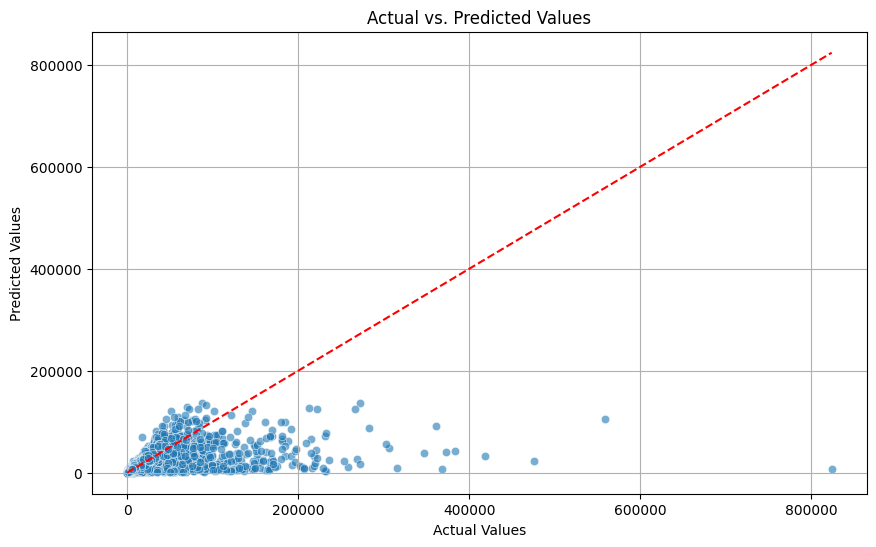

In [43]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual_test, y_actual_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([min(y_actual_test), max(y_actual_test)], [min(y_actual_test), max(y_actual_test)], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

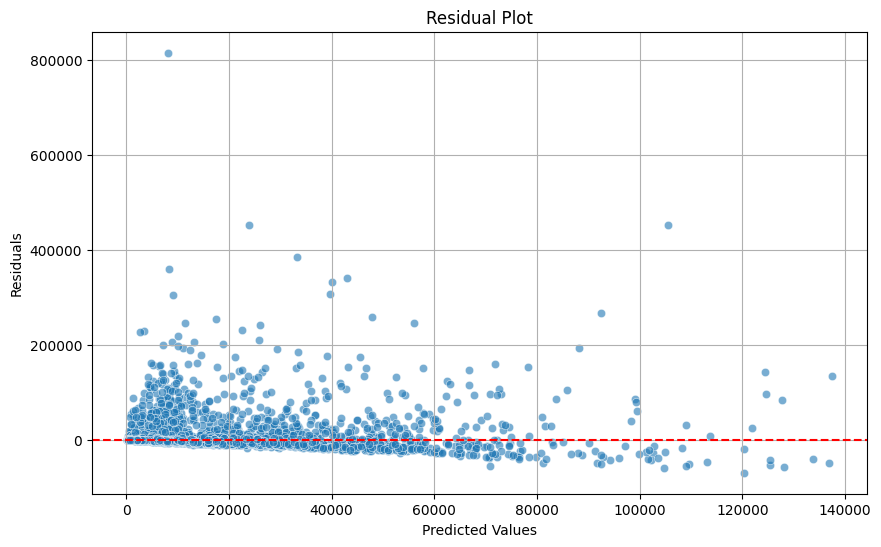

In [44]:
# Residual Plot
residuals = y_actual_test - y_actual_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_actual_pred, residuals, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

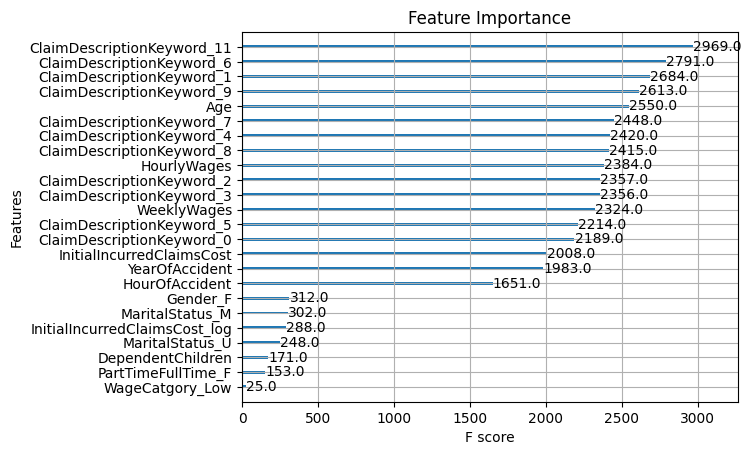

In [45]:
# Feature importance plot
xgb.plot_importance(model_best)
plt.title('Feature Importance')
plt.show()

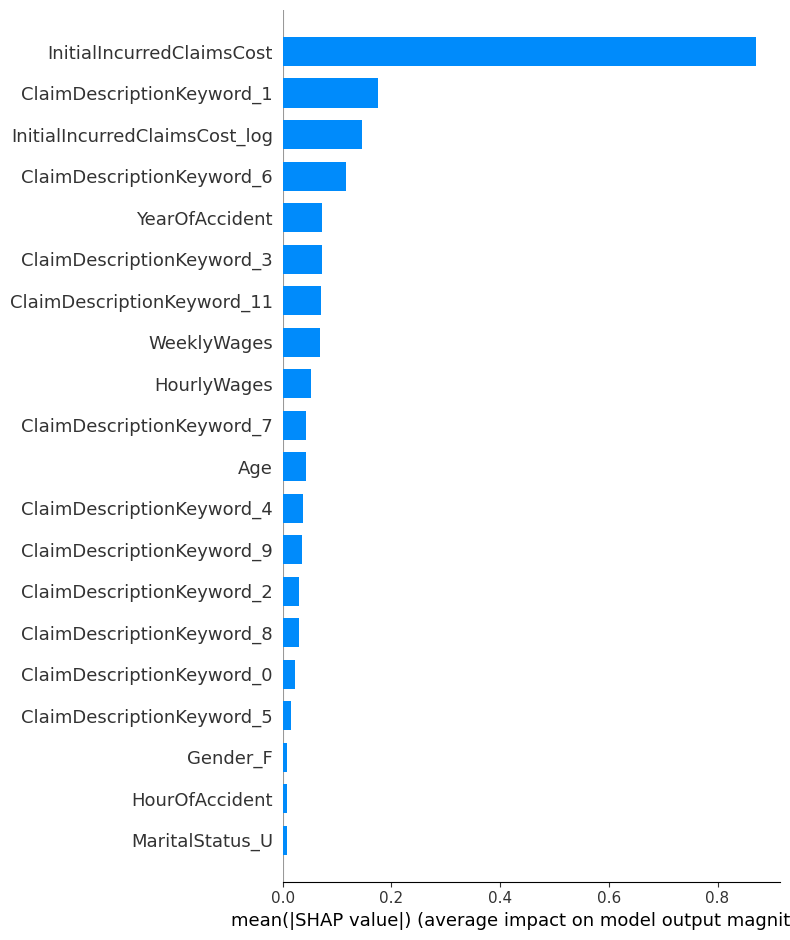

In [46]:
# plot the SHAP to see the feature importance
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type='bar')

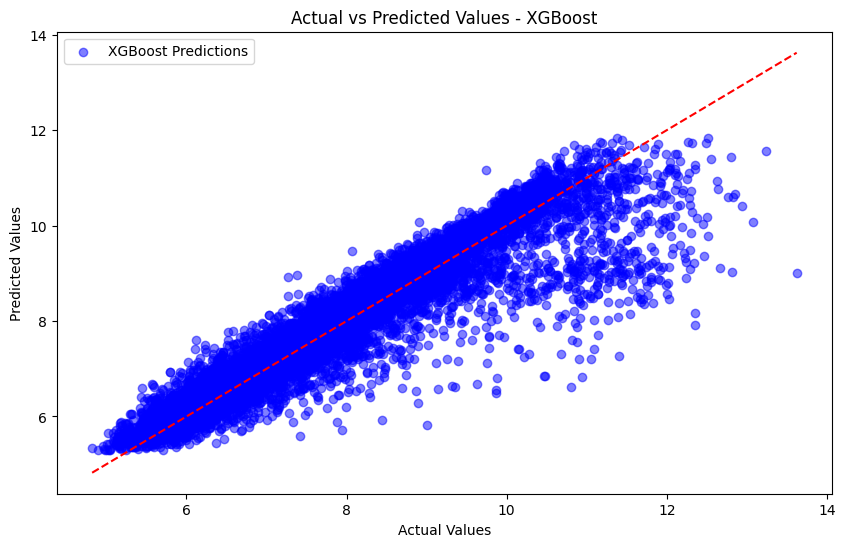

In [47]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for XGBoost
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='XGBoost Predictions')

# # Plot actual vs predicted for Decision Tree
# plt.scatter(y_test, y_pred_dt, color='green', alpha=0.5, label='Decision Tree Predictions')

# Plot a diagonal line representing the perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Predicted Values - XGBoost')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

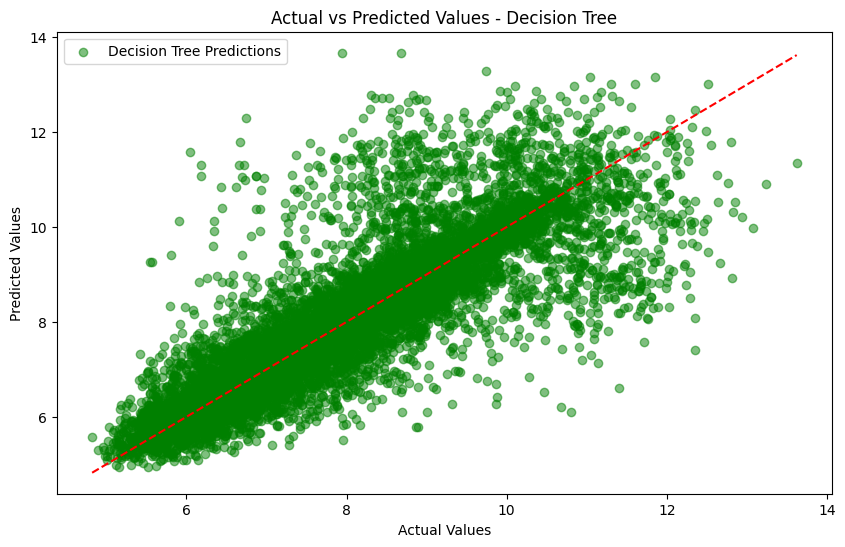

In [48]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for XGBoost
# plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='XGBoost Predictions')

# # Plot actual vs predicted for Decision Tree
plt.scatter(y_test, y_pred_dt, color='green', alpha=0.5, label='Decision Tree Predictions')

# Plot a diagonal line representing the perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Predicted Values - Decision Tree')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

#### Identify complex claims

There is no specific rule here to define a complex claim. So to define the complex claims we can consider the following process:
- Machine Learning approach: Using unsupervised learning to cluster the claims and identify the complex claim clusters by comparing the initial estimate cost with the actual claim cost for that cluter.
- Rule based approach: Define a threshold for each features and if the claim has more than 3 features above the threshold, then it is a complex claim. (Not Implemented)


To find the righe person to handle the complex claims, we can use the following approach:
- calculate the similarity between the claims in the same cluster and find the most similar claims to the new claim and assign the new claim to the person who handled the similar claims.

So for a given claim, we will use k-mean model to predict the cluster and identify if it's a complex claim or not. If it's a complex claim, we will find the most similar claims in the same cluster and triage them to the person who handled those similar claims.

In [49]:
from sklearn.decomposition import PCA
from model import KMeansClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [50]:
# define feature columns
kmean_final_df = clean_df.copy()
kmean_features_columns = ['ClaimDescriptionKeyword_0', 'ClaimDescriptionKeyword_1', 'ClaimDescriptionKeyword_2', 'ClaimDescriptionKeyword_3', 'ClaimDescriptionKeyword_4', 
                        'ClaimDescriptionKeyword_5', 'ClaimDescriptionKeyword_6', 'ClaimDescriptionKeyword_7', 'ClaimDescriptionKeyword_8', 'ClaimDescriptionKeyword_9', 
                        'ClaimDescriptionKeyword_10', 'ClaimDescriptionKeyword_11']

# Standardize the features
for col in kmean_features_columns:
    kmean_final_df[col] = (kmean_final_df[col] - kmean_final_df[col].mean()) / kmean_final_df[col].std()

In [51]:
##### Train k-means model #####
X = kmean_final_df[kmean_features_columns]
y = clean_df[['UltimateIncurredClaimCost_log', 'UltimateIncurredClaimCost']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
baseline_data = X_train.merge(y_train, left_index=True, right_index=True)

# initialize the KMeansClustering class
kmeans_clustering = KMeansClustering(df=X_train, random_state=0)

# fit the model
X_train_res, data_scaled, kmeans, best_k = kmeans_clustering.perform_clustering(start_k=10, end_k=30, interval=5)

INFO:model:Scaling features...
INFO:model:Starting to find the best k value...
Finding best k: 100%|██████████| 5/5 [01:01<00:00, 12.23s/it]
INFO:model:Best k value found: 15


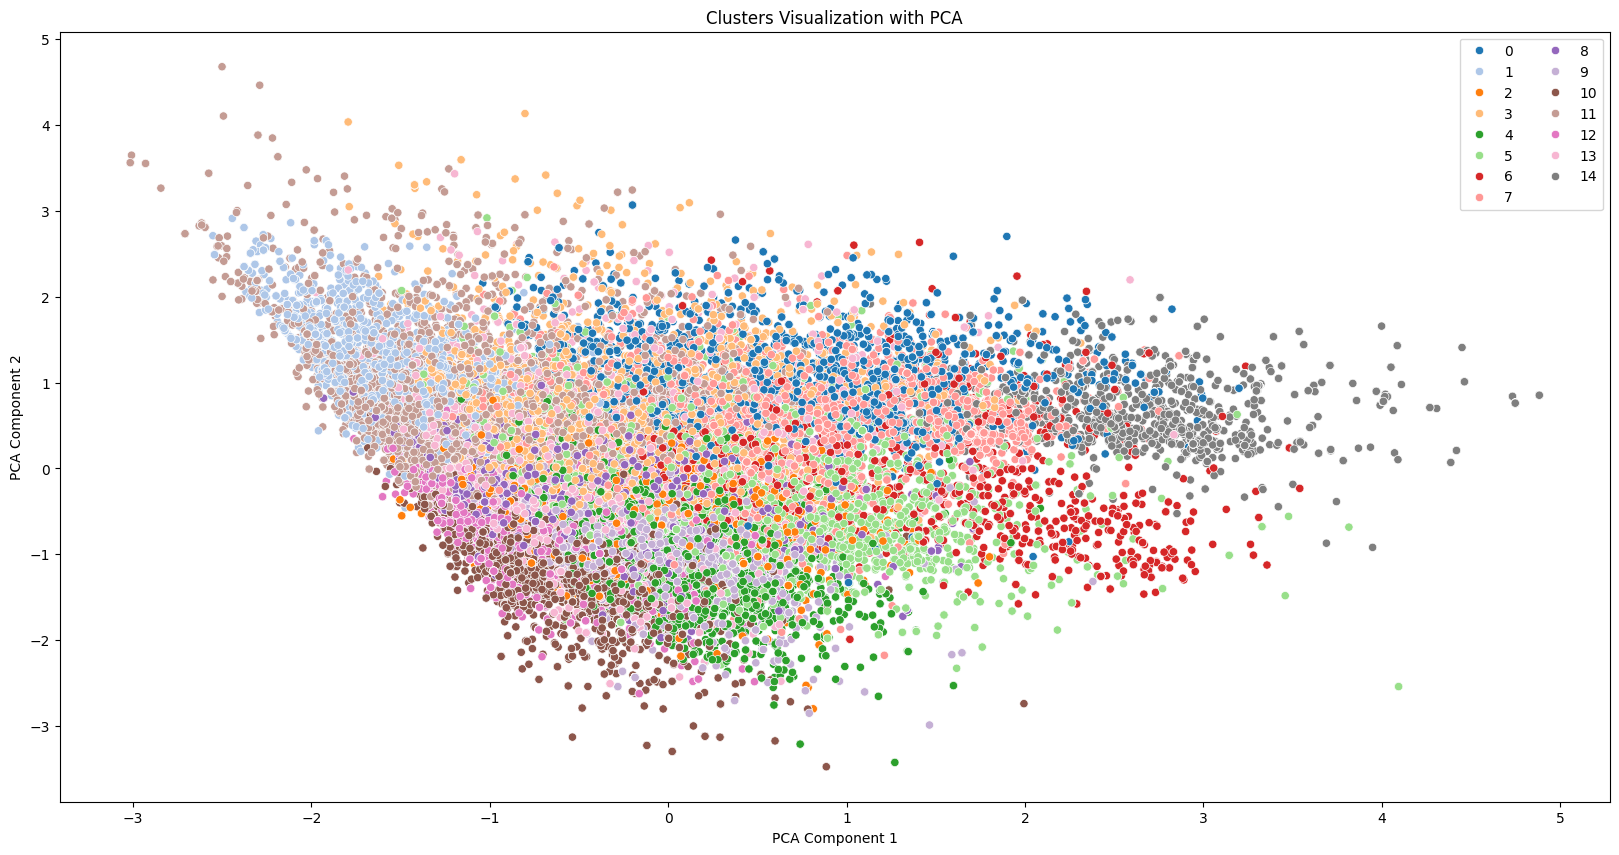

In [52]:
# plot the pca to see the clusters
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_train_res.drop('Cluster', axis=1))

plt.figure(figsize=(20, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=X_train_res['Cluster'], palette='tab20')
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=2)
plt.show()

In [53]:
# get UltimateIncurredClaimCost
X_train_res = X_train_res.merge(y_train, left_index=True, right_index=True)
# get ClaimNumber, InitialIncurredClaimsCost from kmean_final_df
X_train_res = X_train_res.merge(kmean_final_df[['ClaimNumber', 'InitialIncurredClaimsCost']], left_index=True, right_index=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/7d/ybg4b9fd0klcqvj67rnbsfk40000gn/T/ipykernel_69245/3691978204.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=X_train_res, palette='viridis', ax=axes[i])
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/v

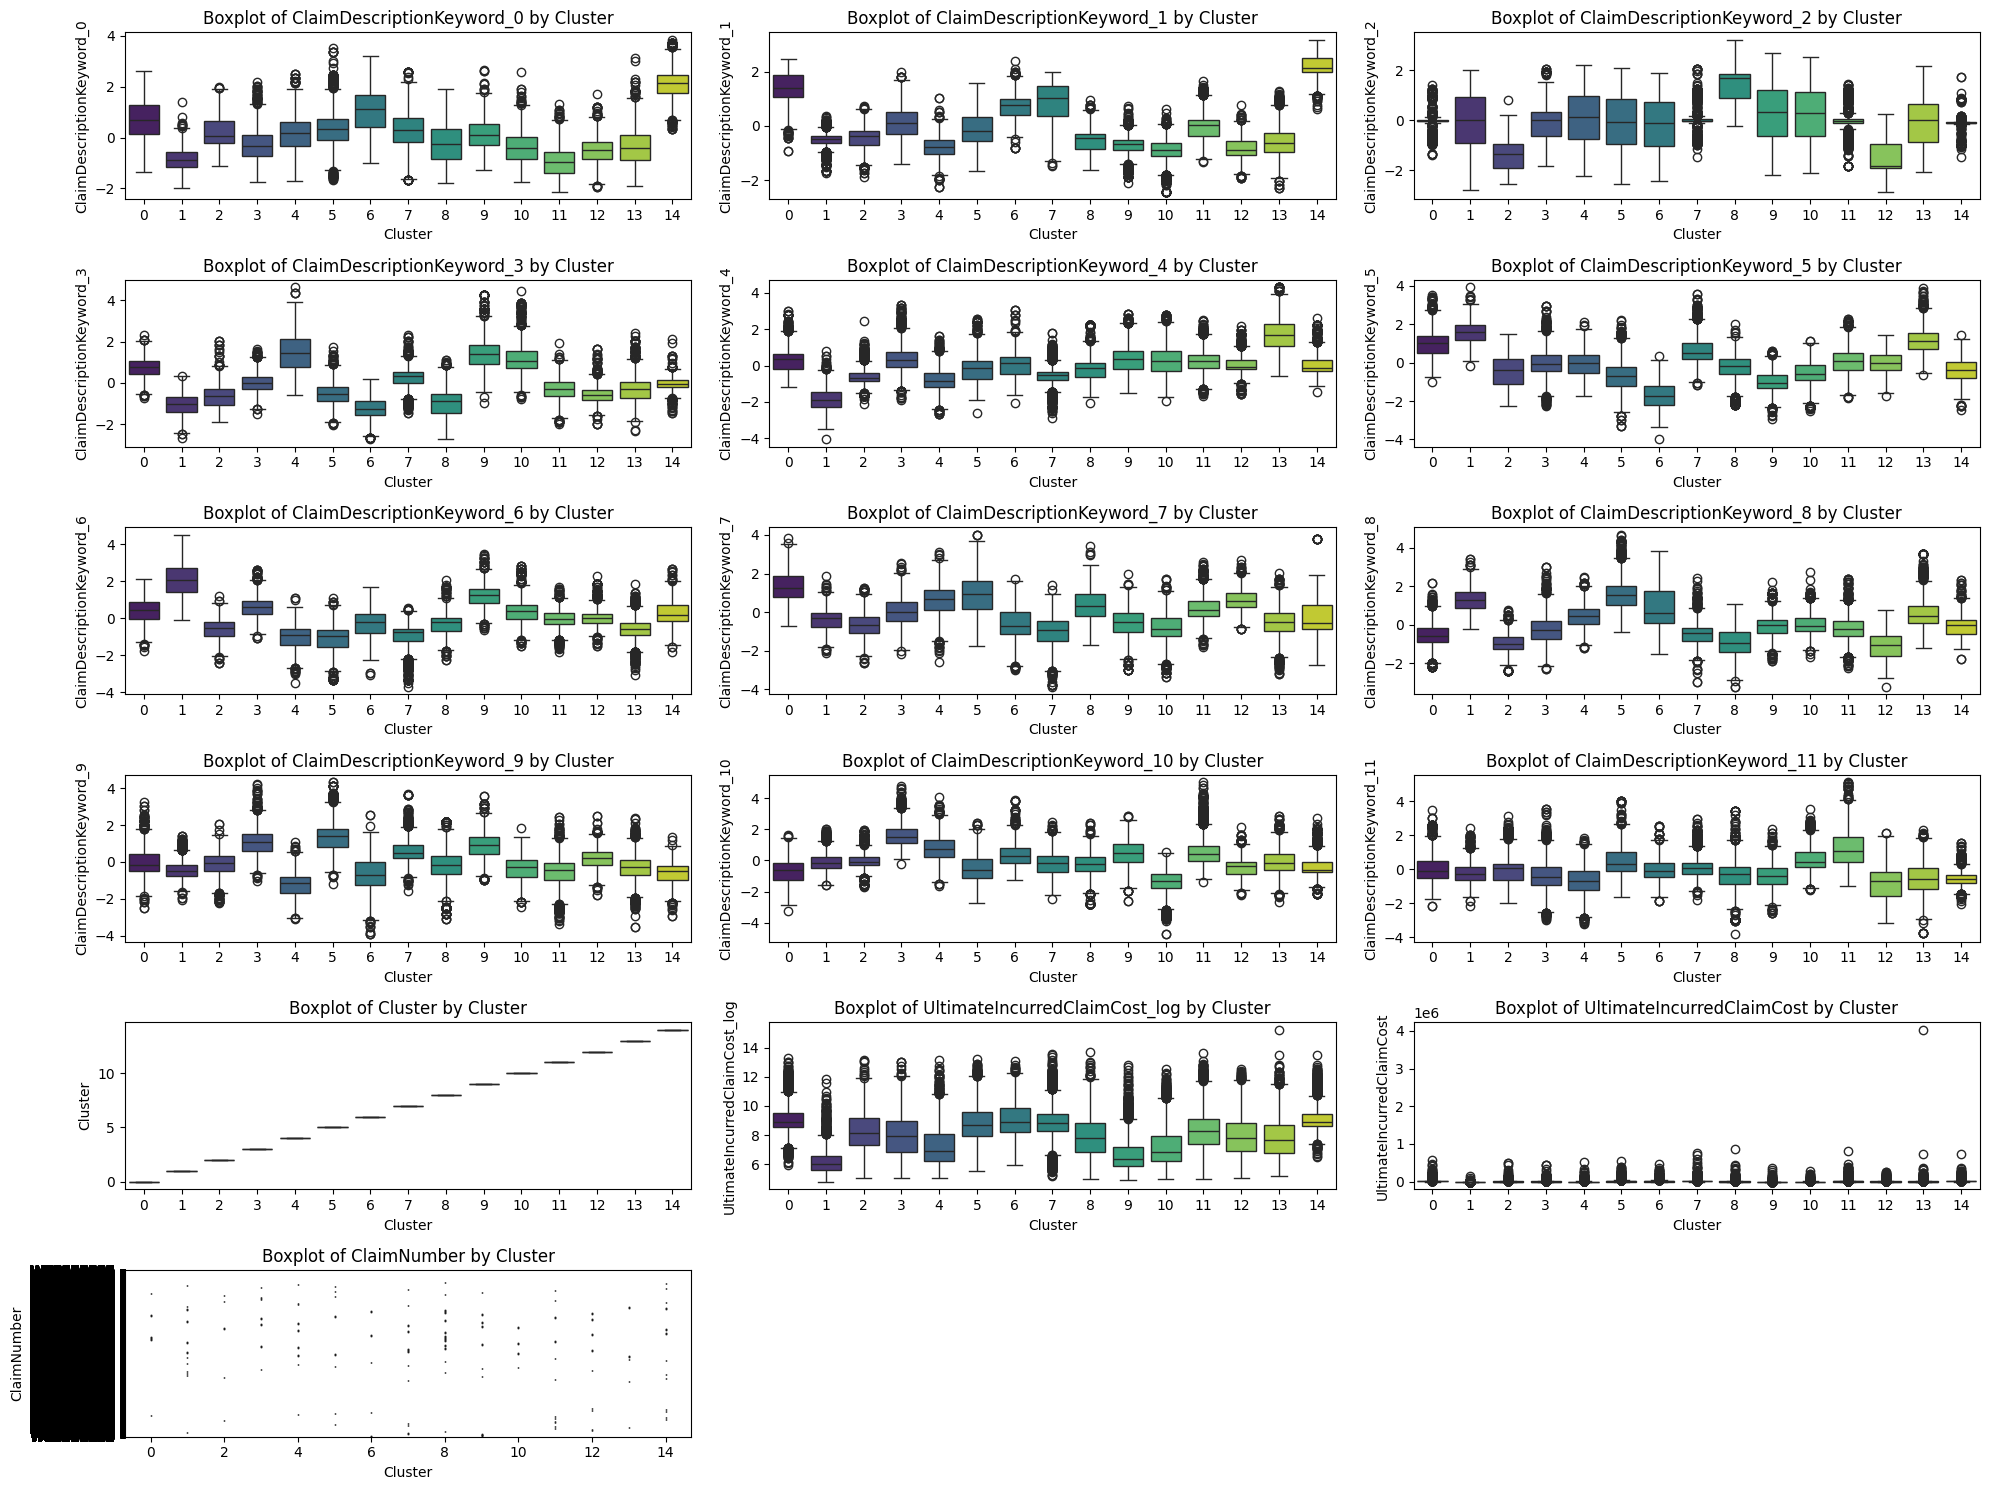

In [54]:
# Extract features excluding the 'Cluster' column
features = X_train_res.columns[:-1]

# Calculate the number of rows and columns for the subplots grid
ncols = 3
nrows = (len(features) // ncols) + (len(features) % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
axes = axes.flatten()

# Plot feature distribution for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=X_train_res, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Cluster')

# Remove any empty subplots if the number of features isn't a perfect multiple of ncols
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [55]:
# Calculate the average initial incurred claim cost per cluster
claim_cost_cluster_df = X_train_res.groupby('Cluster')[['UltimateIncurredClaimCost', 'InitialIncurredClaimsCost']].mean().reset_index().rename(columns={'UltimateIncurredClaimCost': 'AverageUltimateIncurredClaimCost', 'InitialIncurredClaimsCost': 'AverageInitialIncurredClaimsCost'})
# Calculate the cost gap between the average ultimate incurred claim cost and average initial incurred claim cost
claim_cost_cluster_df['cost_gap'] = claim_cost_cluster_df['AverageUltimateIncurredClaimCost'] - claim_cost_cluster_df['AverageInitialIncurredClaimsCost']

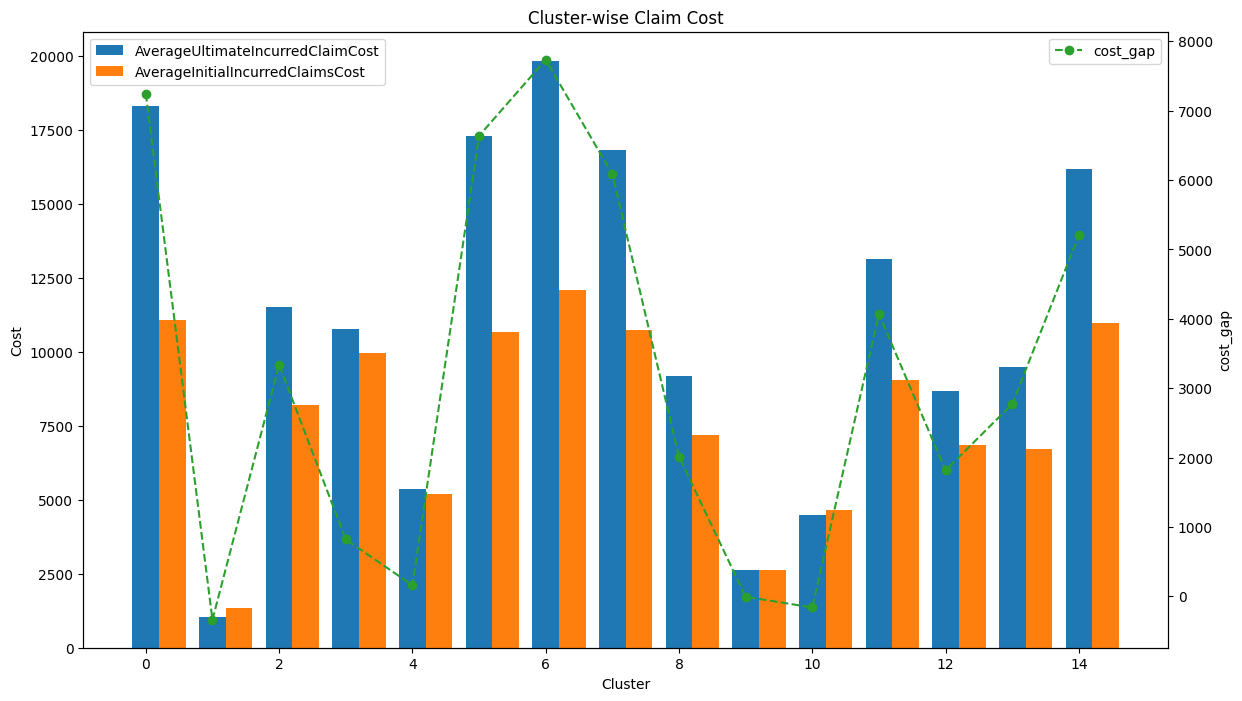

In [56]:
# Visualize the cluster-wise claim costs
fig, ax = plt.subplots(figsize=(14, 8))

# Plot AverageUltimateIncurredClaimCost
ax.bar(claim_cost_cluster_df['Cluster'], claim_cost_cluster_df['AverageUltimateIncurredClaimCost'], width=0.4, label='AverageUltimateIncurredClaimCost', align='center')

# Plot AverageInitialIncurredClaimsCost
ax.bar(claim_cost_cluster_df['Cluster'] + 0.4, claim_cost_cluster_df['AverageInitialIncurredClaimsCost'], width=0.4, label='AverageInitialIncurredClaimsCost', align='center')

# Add the cost_gap line
ax2 = ax.twinx()
ax2.plot(claim_cost_cluster_df['Cluster'], claim_cost_cluster_df['cost_gap'], color='tab:green', linestyle='dashed', marker='o', label='cost_gap')

# Adding labels and title
ax.set_xlabel('Cluster')
ax.set_ylabel('Cost')
ax2.set_ylabel('cost_gap')
plt.title('Cluster-wise Claim Cost')

# Adding legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Based on the cost gap between the Average Ultimate Incurred Claim Cost and the Average Initial Incurred Claim Cost, Clusters 0, 2, 5, 6, 7, 11, 14 are identified as complex clusters, each with a cost gap exceeding 3000.

To validate the results from k-mean model, there is one assumption we made:
there is no source of truth data to determine if a claim is complex, when validating the results from the K-means prediction, we will assume a claim is considered complex if the cost gap between the initial claim and the ultimate claim exceeds 3000.


In [57]:
# define complex claim clusters threshold
threshold_score = 3000
# Get the clusters with a cost gap greater than the threshold
complex_claim_clusters = claim_cost_cluster_df.loc[claim_cost_cluster_df['cost_gap'] > threshold_score]['Cluster'].tolist()
# identify the complex claim
X_train_res['complex_claim'] = X_train_res['Cluster'].apply(lambda x: 1 if x in complex_claim_clusters else 0)

In [58]:
##### Test for K mean Model #####
# predict for the test data
res = kmeans.predict(X_test[kmean_features_columns])
X_test_res = X_test
X_test_res['Cluster'] = res

# get ClaimNumber and UltimateIncurredClaimCost from kmean_final_df
X_test_res = X_test_res.merge(y_test, left_index=True, right_index=True)
X_test_res = X_test_res.merge(kmean_final_df[['ClaimNumber', 'InitialIncurredClaimsCost']], left_index=True, right_index=True)
# find complex claim in the test data
X_test_res['complex_claim'] = X_test_res['Cluster'].apply(lambda x: 1 if x in complex_claim_clusters else 0)
complex_claims_df = X_test_res[X_test_res['complex_claim'] == 1]

# get abs value of cost gap for x_test_res
X_test_res['cost_gap'] = X_test_res['UltimateIncurredClaimCost'] - X_test_res['InitialIncurredClaimsCost']
X_test_res['cost_gap'] = X_test_res['cost_gap'].abs()
X_test_res['actual_complex_claim'] = X_test_res['cost_gap'].apply(lambda x: 1 if x > threshold_score else 0)

/Users/yuzhouzhang/.pyenv/versions/3.11.6/envs/suncorp_test/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


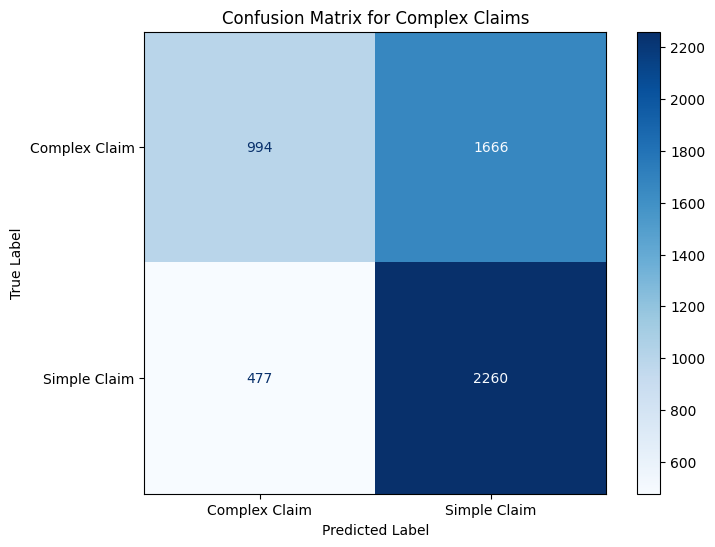

In [59]:

# confusion matrix graph for complex claim and actual complex claim
cm = confusion_matrix(X_test_res['complex_claim'], X_test_res['actual_complex_claim'], labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Complex Claim', 'Simple Claim'])
# Plot the confusion matrix with customization
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')

# Add titles and labels
plt.title('Confusion Matrix for Complex Claims')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [60]:
# calculate the precision, recall, and f1-score
precision = precision_score(X_test_res['complex_claim'], X_test_res['actual_complex_claim'])
recall = recall_score(X_test_res['complex_claim'], X_test_res['actual_complex_claim'])
f1 = f1_score(X_test_res['complex_claim'], X_test_res['actual_complex_claim'])

print('Precision:', precision) 
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.6757307953772943
Recall: 0.3736842105263158
F1 Score: 0.4812394093439845


In [61]:
##### Top 3 Similar Claims - Target to right person #####
complex_claims_df = X_test_res[X_test_res['complex_claim'] == 1]
# Calculate distances between the input point and all points in the same cluster
distances = pairwise_distances(complex_claims_df[kmean_features_columns], X_train_res[kmean_features_columns])
# get top3 for each distance
top3_indices = np.argsort(distances, axis=1)[:, :3]
# find the index in X_train_res and get the ClaimNumber
top3_claim_numbers = X_train_res.iloc[top3_indices.flatten()]['ClaimNumber'].values.reshape(-1, 3)
# attached the top3 claim numbers to the complex_claims_df
complex_claims_df['Top3SimilarClaims'] = top3_claim_numbers.tolist()
# calculate the cost gap
complex_claims_df['cost_gap'] = complex_claims_df['UltimateIncurredClaimCost'] - complex_claims_df['InitialIncurredClaimsCost'] 

/var/folders/7d/ybg4b9fd0klcqvj67rnbsfk40000gn/T/ipykernel_69245/3037427431.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complex_claims_df['Top3SimilarClaims'] = top3_claim_numbers.tolist()
/var/folders/7d/ybg4b9fd0klcqvj67rnbsfk40000gn/T/ipykernel_69245/3037427431.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complex_claims_df['cost_gap'] = complex_claims_df['UltimateIncurredClaimCost'] - complex_claims_df['InitialIncurredClaimsCost']


In [62]:
complex_claims_df[['ClaimNumber', 'complex_claim', 'actual_complex_claim', 'Top3SimilarClaims']][:50]

ClaimNumber  complex_claim  actual_complex_claim  \
49674   WC9868546              1                     1   
27880   WC6451332              1                     1   
33605   WC3698958              1                     0   
29900   WC6963515              1                     0   
21154   WC6287245              1                     0   
3751    WC9193117              1                     1   
30295   WC7967078              1                     1   
25089   WC9359735              1                     1   
13110   WC8430384              1                     0   
31540   WC2117172              1                     0   
38186   WC9632769              1                     1   
44310   WC6756322              1                     0   
11619   WC7277087              1                     1   
7598    WC7174594              1                     1   
8607    WC2919987              1                     1   
52314   WC7106813              1                     0   
23467   WC4683628              1                     1   
32831   WC4646067              1                     1   
4883    WC6878173              1                     0   
48401   WC9507832              1                     1   
28376   WC9969787              1                     0   
25129   WC6749648              1                     0   
40092   WC5068627              1                     0   
9026    WC6570909              1                     0   
49177   WC7287782              1                     0   
41137   WC5124651              1                     0   
9647    WC3708657              1                     0   
9093    WC2405309              1                     0   
50123   WC2376757              1                     0   
28923   WC3378239              1                     0   
20458   WC6772421              1                     0   
27735   WC1697028              1                     0   
20766   WC8034753              1                     1   
14889   WC4067792              1                     0   
25639   WC2459981              1                     0   
11834   WC5909448              1                     0   
52142   WC8369838              1                     1   
29216   WC6952145              1                     0   
53024   WC8556744              1                     0   
14664   WC6381413              1                     1   
6020    WC8054415              1                     0   
47623   WC9773413              1                     1   
24800   WC3273429              1                     0   
32397   WC5308507              1                     0   
42931   WC4394201              1                     0   
20315   WC6232958              1                     0   
51460   WC9032215              1                     0   
11667   WC1706308              1                     1   
17282   WC8858305              1                     1   
5373    WC7191974              1                     0   

                       Top3SimilarClaims  
49674  [WC5605324, WC2501554, WC3393481]  
27880  [WC9725763, WC5377811, WC7987286]  
33605  [WC5940670, WC3313385, WC6926034]  
29900  [WC8518148, WC6479733, WC8767494]  
21154  [WC3888161, WC5124940, WC1935283]  
3751   [WC6829420, WC6172169, WC6560735]  
30295  [WC4570216, WC4134451, WC3496305]  
25089  [WC5883867, WC2538842, WC4241911]  
13110  [WC7385769, WC2744922, WC1603006]  
31540  [WC3403050, WC1737960, WC5663845]  
38186  [WC4967758, WC9747620, WC6541753]  
44310  [WC5214469, WC6167752, WC4581772]  
11619  [WC2073693, WC4090449, WC9197946]  
7598   [WC9032166, WC3985758, WC4776255]  
8607   [WC1622253, WC2264721, WC7888113]  
52314  [WC7497093, WC3180999, WC5341359]  
23467  [WC4173380, WC4383684, WC2752521]  
32831  [WC6028312, WC2851794, WC6586989]  
4883   [WC7747294, WC9728727, WC9383245]  
48401  [WC3047600, WC7167074, WC2673918]  
28376  [WC2067348, WC1698016, WC3372369]  
25129  [WC4173380, WC4383684, WC2752521]  
40092  [WC6693048, WC3728474, WC1935283]  
9026   [WC23729

### Summary
- Implement XGBRegressor for claim cost prediction, achieving performance approximately 40% better than the Decision Tree model.

- Implement the K-means algorithm to group claims into different clusters for identifying complex claims. Utilize the distance between features for each claim to find similar claims and forward them to the claim handlers.

### Future Work
- Collect additional text data to improve performance.

- Gather historical claims for the same individual. 

- Implement rule-based logic to identify complex claims

